# A Manual Regristation Pipeline for Processing

In [13]:
import numpy as np
import copy
import open3d as o3d
import os
import sys

from numpy.linalg import inv

# monkey patches visualization and provides helpers to load geometries
sys.path.append('..')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

## Utility Functions

In [14]:

def demo_crop_geometry():
    print("Demo for manual geometry cropping")
    print(
        "1) Press 'Y' twice to align geometry with negative direction of y-axis"
    )
    print("2) Press 'K' to lock screen and to switch to selection mode")
    print("3) Drag for rectangle selection,")
    print("   or use ctrl + left click for polygon selection")
    print("4) Press 'C' to get a selected geometry and to save it")
    print("5) Press 'F' to switch to freeview mode")
    pcd = o3d.io.read_point_cloud("../../test_data/ICP/cloud_bin_0.pcd")
    o3d.visualization.draw_geometries_with_editing([pcd])

def draw_registration_color(source,target,transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])    

def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp]) # causing problem
    
def pick_points(pcd, filename, fileid):
    print("")
    print(
        "1) Please pick at least three correspondences using [shift + left click]"
    )
    print("   Press [shift + right click] to undo point picking")
    print("2) After picking points, press 'Q' to close the window")
    vis = o3d.visualization.VisualizerWithEditing()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()  # user picks points
    vis.capture_screen_image("calibration/%s_%d.png" % (filename, fileid))    
    vis.destroy_window()
    print("")
    return vis.get_picked_points()

In [2]:
# bounding boxes - cow 186
box_11=[1.05552,1.32026,1.008]
center_11=[-0.193823,0.140330,1.255]
box_12=[1.24794,1.24481,0.85]
center_12=[-0.407762,-0.006689,1.101]
box_13=[1.62464,1.35825,1.254]
center_13=[0.190396,0.188945,1.276]
box_14 =[1.47061,1.6612,1.017]
center_14 = [0.091901,-0.169477,1.3215]
box_15 =[1.62371,1.70774,1.116]
center_15=[-0.217166,0.00351059,1.49]
box_16=[1.52361,1.59782,1.004]
center_16=[-0.301344,-0.137952,1.343]
box_17=[1.67105,1.51799,1.028]
center_17=[0.428267,0.071340,1.54]
box_18=[1.57935,1.58814,0.819]
center_18=[0.114024,-0.019738,1.369500]
box_19=[0.679421,0.869247,0.406]
box_19=[0.053226,0.000228,0.794]

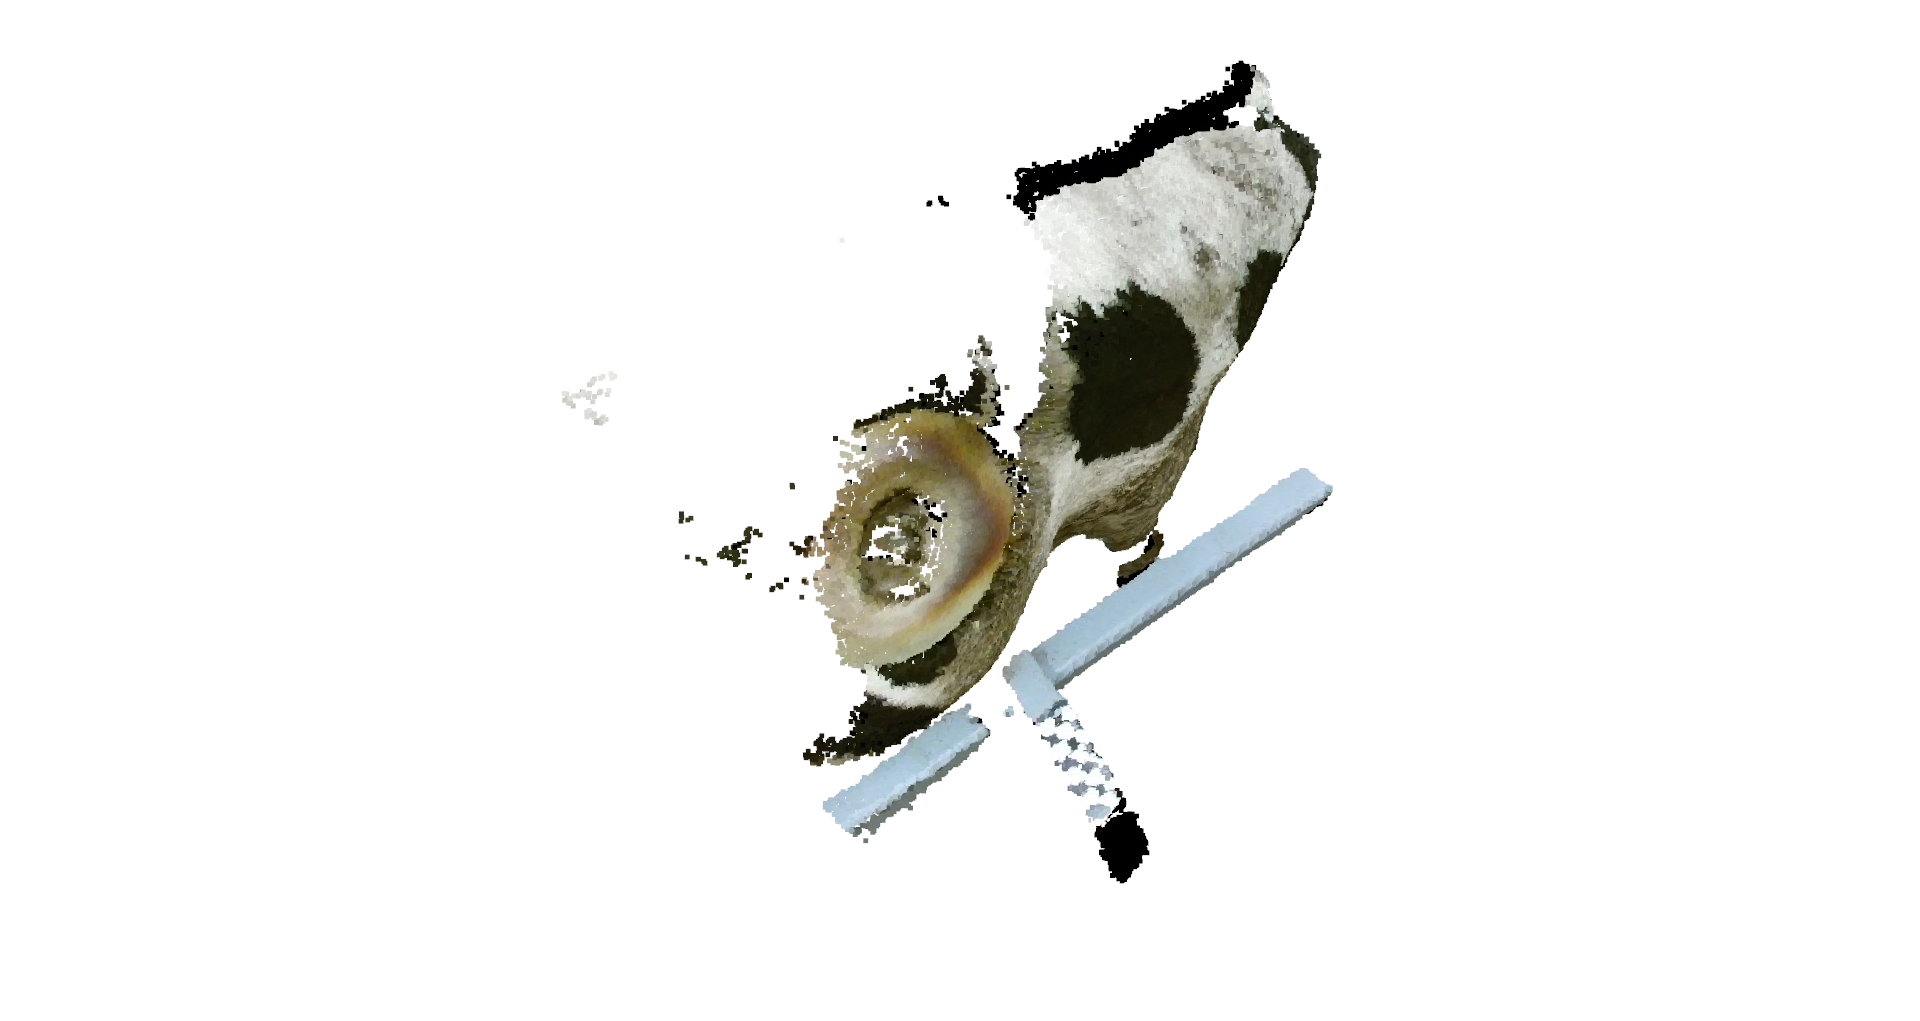

In [113]:
[p,bbox] = cow_crop(source,box_11,center_11)

In [3]:
def box_center_to_corner(box):
    # To return
    corner_boxes = np.zeros((8, 3))

    translation = box[0:3]
    h, w, l = box[3], box[4], box[5]
    rotation = box[6]

    # Create a bounding box outline
    bounding_box = np.array([
        [-l/2, -l/2, l/2, l/2, -l/2, -l/2, l/2, l/2],
        [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2],
        [-h/2, -h/2, -h/2, -h/2, h/2, h/2, h/2, h/2]])

    # Standard 3x3 rotation matrix around the Z axis
    rotation_matrix = np.array([
        [np.cos(rotation), -np.sin(rotation), 0.0],
        [np.sin(rotation), np.cos(rotation), 0.0],
        [0.0, 0.0, 1.0]])

    # Repeat the [x, y, z] eight times
    eight_points = np.tile(translation, (8, 1))

    # Translate the rotated bounding box by the
    # original center position to obtain the final box
    corner_box = np.dot(
        rotation_matrix, bounding_box) + eight_points.transpose()

    return corner_box.transpose()

In [5]:
XX = box_11 + center_11 + [0]
print(XX)
corner_box= box_center_to_corner(XX)
print(corner_box)

[1.05552, 1.32026, 1.008, -0.193823, 0.14033, 1.255, 0]
[[0.42802   1.390425  1.1049115]
 [0.42802   1.250095  1.1049115]
 [1.68302   1.250095  1.1049115]
 [1.68302   1.390425  1.1049115]
 [0.42802   1.390425  0.9110885]
 [0.42802   1.250095  0.9110885]
 [1.68302   1.250095  0.9110885]
 [1.68302   1.390425  0.9110885]]


In [7]:
type(corner_box)

numpy.ndarray

In [8]:
XX = box_11 + center_11 + [0]
print(XX)
corner_box= box_center_to_corner(XX)
print(corner_box)
# Our lines span from points 0 to 1, 1 to 2, 2 to 3, etc...
lines = [[0, 1], [1, 2], [2, 3], [0, 3],
         [4, 5], [5, 6], [6, 7], [4, 7],
         [0, 4], [1, 5], [2, 6], [3, 7]]

# Use the same color for all lines
colors = [[1, 0, 0] for _ in range(len(lines))]

line_set = o3d.geometry.LineSet()
line_set.points = o3d.utility.Vector3dVector(corner_box)
line_set.lines = o3d.utility.Vector2iVector(lines)
line_set.colors = o3d.utility.Vector3dVector(colors)

# Create a visualization object and window
vis = o3d.visualization.Visualizer()
vis.create_window()

# Display the bounding boxes:
vis.add_geometry(line_set)

True

In [104]:
def cow_crop(pcd, dims,center):
    x_min = center[0] - 0.5*dims[0]
    y_min = center[1] - 0.5*dims[1]
    z_min = center[2] - 0.5*dims[2]

    x_max = center[0] + 0.5*dims[0]
    y_max = center[1] + 0.5*dims[1]
    z_max = center[2] + 0.5*dims[2]
    
    bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=(x_min,y_min,z_min), max_bound=(x_max,y_max,z_max))
    cropped_ply = pcd.crop(bbox)
    o3d.visualization.draw_geometries([cropped_ply])
    return cropped_ply,bbox

In [100]:
# Crops registered cows leaving legs and tail 
# form = [x_center, y_center,z_center,x_dim,y_dim,z_dim]
#empty animal dimensions
empty_176 = [-0.037025,-0.319416,1.296917,0.787291,1.87989,1.58896] 
empty_186 = [-0.012054,-0.102507,1.321715,0.674235,1.8186,1.64029] #works only on empty cows
empty_188 = [-0.013330,-0.381407,1.347430,0.675049,1.84128,1.57542]

#full animal dimensions
full_176 = [-0.037025,-0.319416,1.296917,0.787291,1.87989,1.58896]
full_186 = [0.025325,-0.223631,1.341248,0.775879,1.76542,1.5424]
full_188 = [-0.036266,-0.197419,1.339098,0.784221,1.72067,1.5399]

#secondary crop dimensions:
legs_176 = [-0.037024,-0.312837,1.116006,0.587291,1.86673,1.22714]
legs_186 = [-0.012054,-0.088689,1.110445,0.674235,1.79097,1.21775]
legs_188 = [-0.013330,-0.381407,1.347430,0.675049,1.84128,1.57542]

def cow_crop(ply_all_views, dims):
    x_center = dims[0]
    y_center = dims[1]
    z_center = dims[2]

    x_dim = dims[3]
    y_dim = dims[4]
    z_dim = dims[5]
    
    x_min = x_center - 0.5*x_dim
    y_min = y_center - 0.5*y_dim
    z_min = z_center - 0.5*z_dim

    x_max = x_center + 0.5*x_dim
    y_max = y_center + 0.5*y_dim
    z_max = z_center + 0.5*z_dim

    bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=(x_min,y_min,z_min), max_bound=(x_max,y_max,z_max))
    cropped_ply = ply_all_views.crop(bbox)
    o3d.visualization.draw_geometries([cropped_ply])
    return cropped_ply,bbox




## Pair-Wise Registration
### left view
|Source|Target|
|---|---|
|1|2|
|1|3|
|3|4|

### right view
|Source|Target|
|---|---|
|5|6|
|5|7|
|7|8|

### top view
|Source|Target|
|---|---|
|9|1|
|9|5|

### Suggested order:

left12, left31, left34, right56, right57, right78, top93, top95

In [11]:
filepath = '/home/cornea/goowfd/Documents/new_cow_data/all_PLYS'
# filepath = '/home/pupil/elitton/Cow_project/empty_cage_images/all_plys_0001/'

Visualization of two point clouds before manual alignment


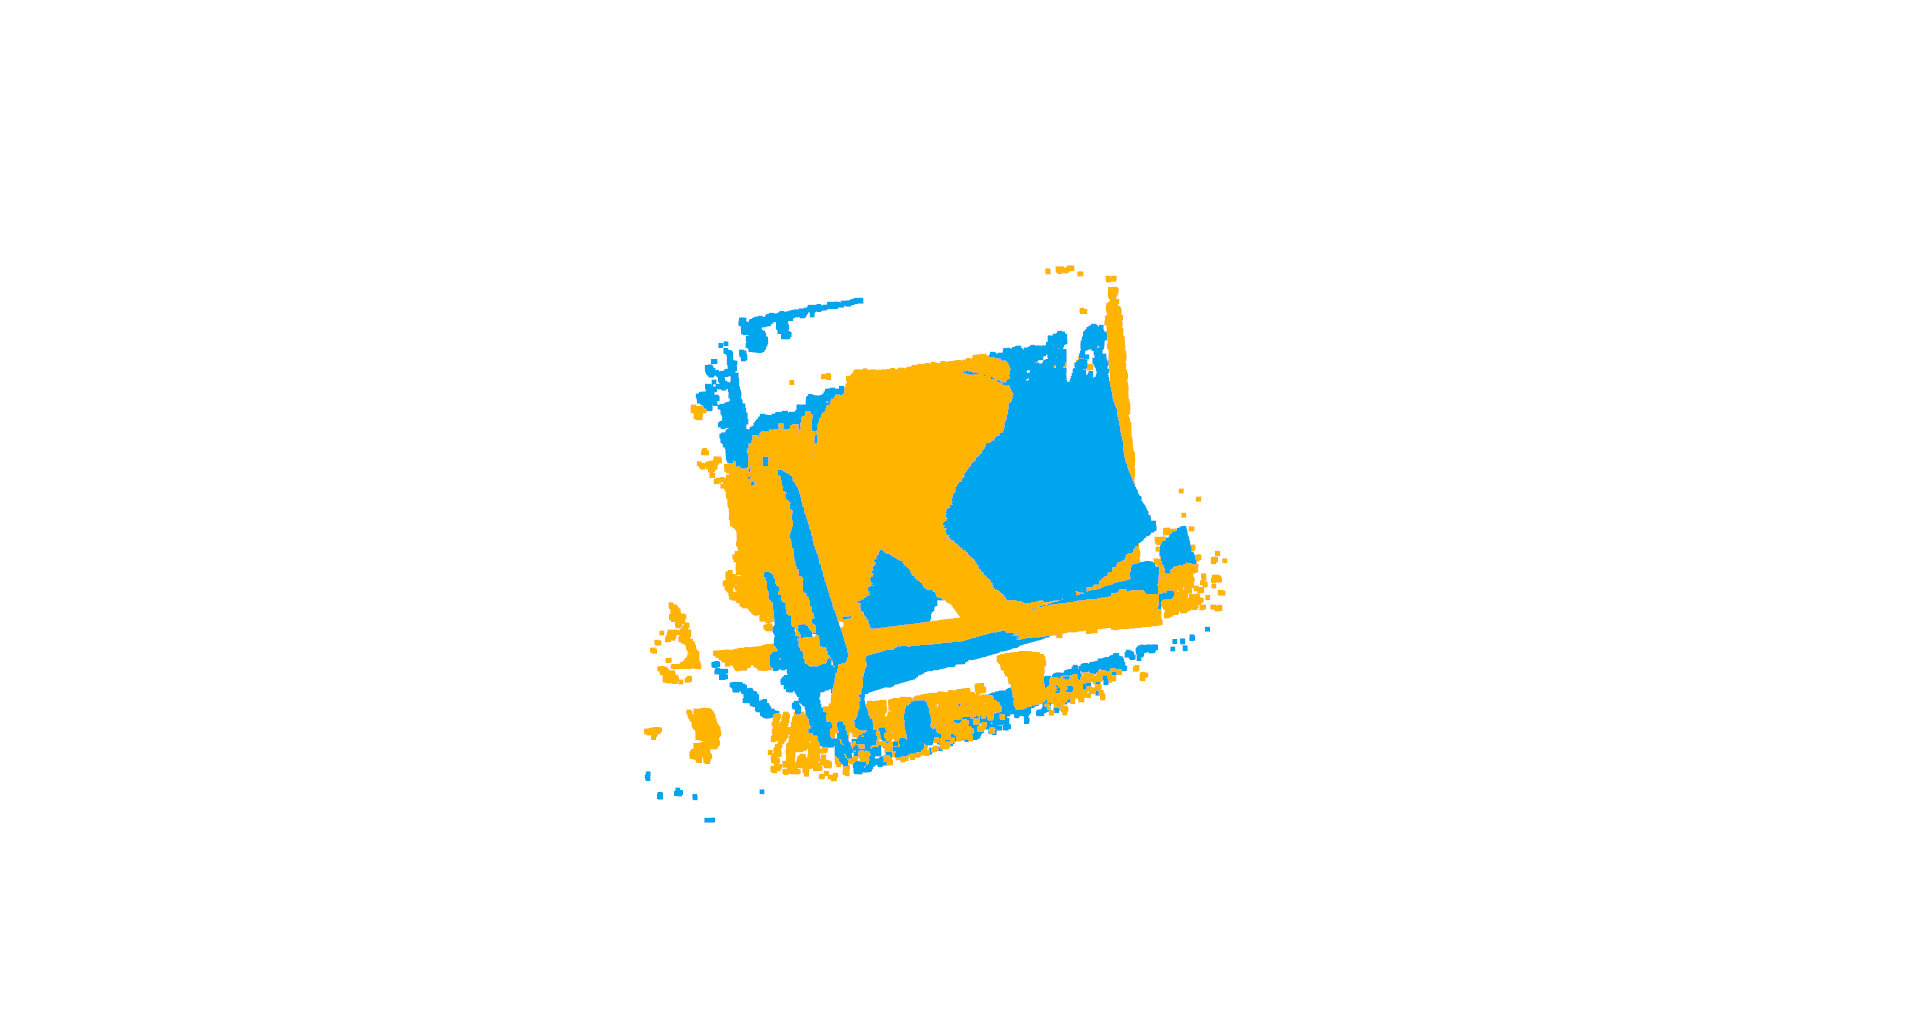

In [15]:
exp_name = 'left13'
source_id = 1
target_id = 3 

#sourceD = o3d.io.read_point_cloud("%s/depthImg_001%d_tobecombined.ply" % (filepath, source_id))
#targetD = o3d.io.read_point_cloud("%s/depthImg_001%d_tobetransformed.ply" % (filepath, target_id))
source = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, source_id))
target = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, target_id))
print("Visualization of two point clouds before manual alignment")
draw_registration_result(source, target, np.identity(4))
#draw_registration_color(source, target, np.identity(4))

In [18]:
#create a deformation by rotation
theta = np.pi/72
deformation = rot_x(theta)
print(deformation)
target_deformed = copy.deepcopy(targetD)
target_deformed.transform(deformation)
o3d.visualization.draw_geometries([target_deformed,targetD])

[[ 1.          0.          0.          0.        ]
 [ 0.          0.99904822 -0.04361939  0.        ]
 [ 0.          0.04361939  0.99904822  0.        ]
 [ 0.          0.          0.          1.        ]]


NameError: name 'targetD' is not defined

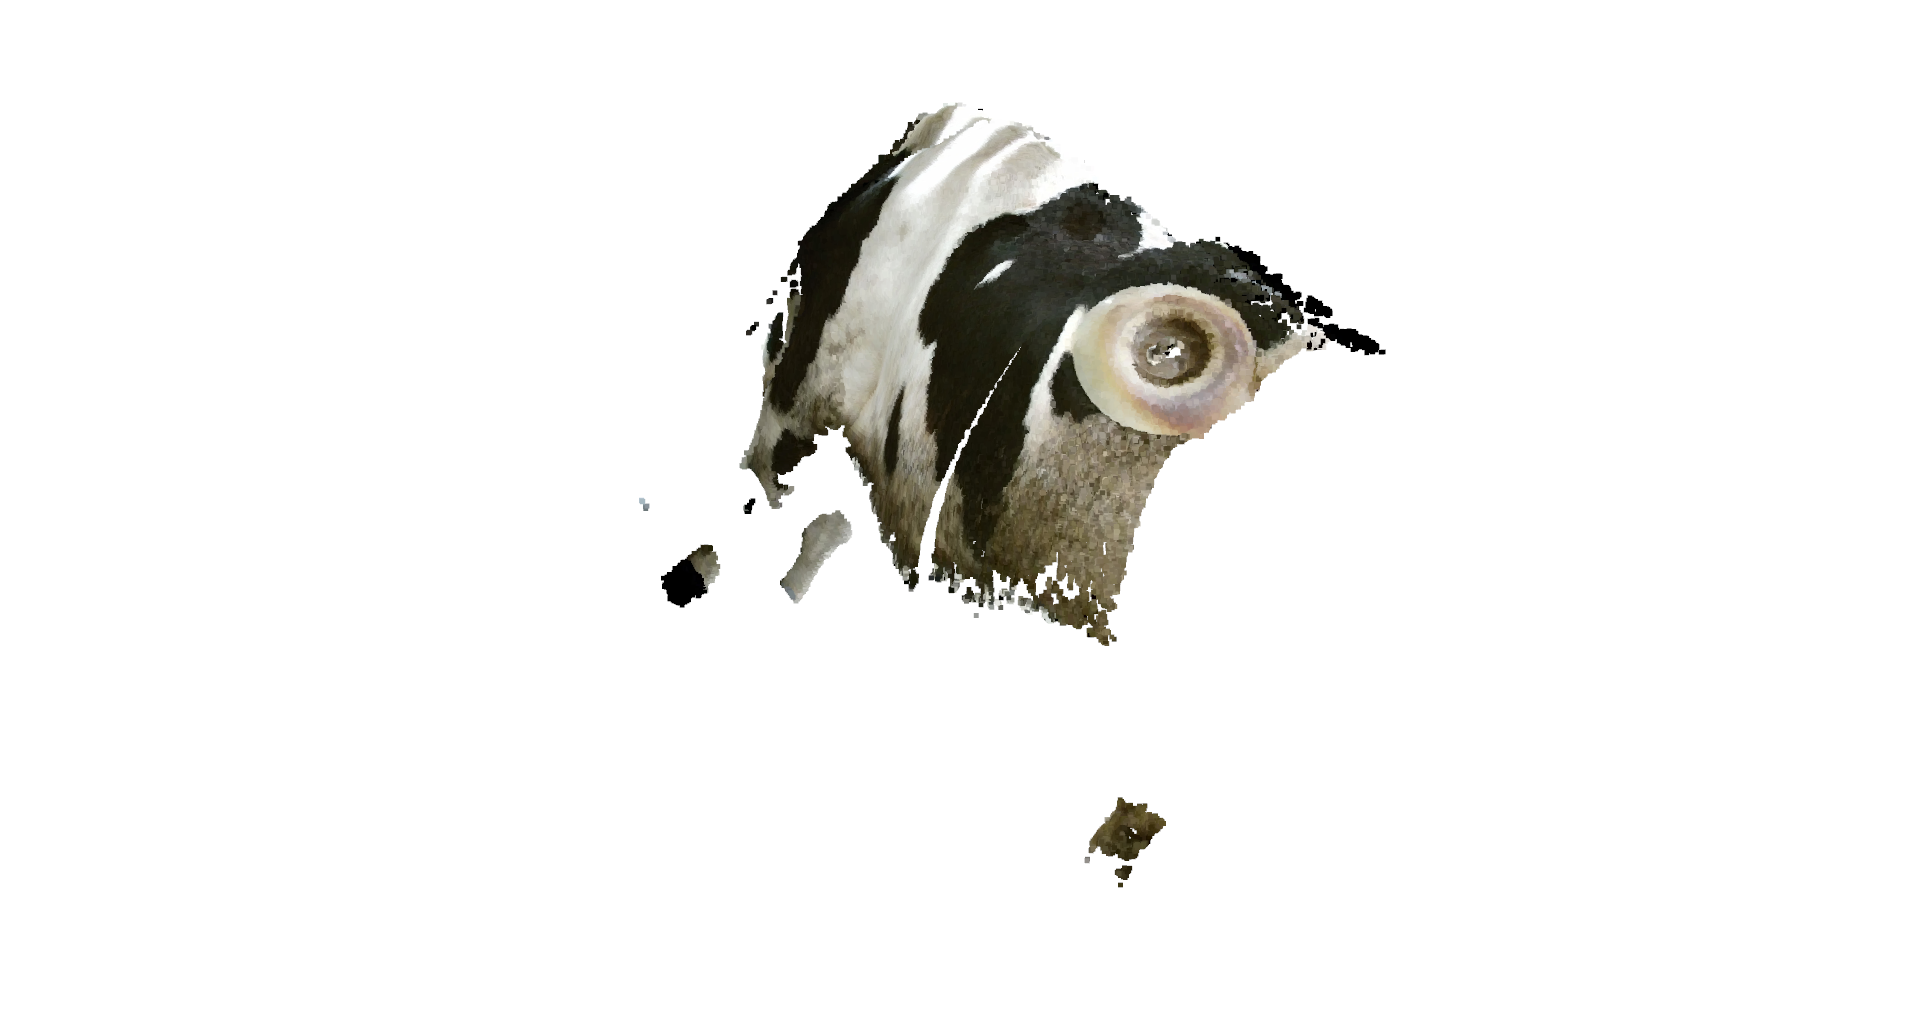

In [86]:
draw_registration_color(sourceD, target_deformed, np.identity(4))

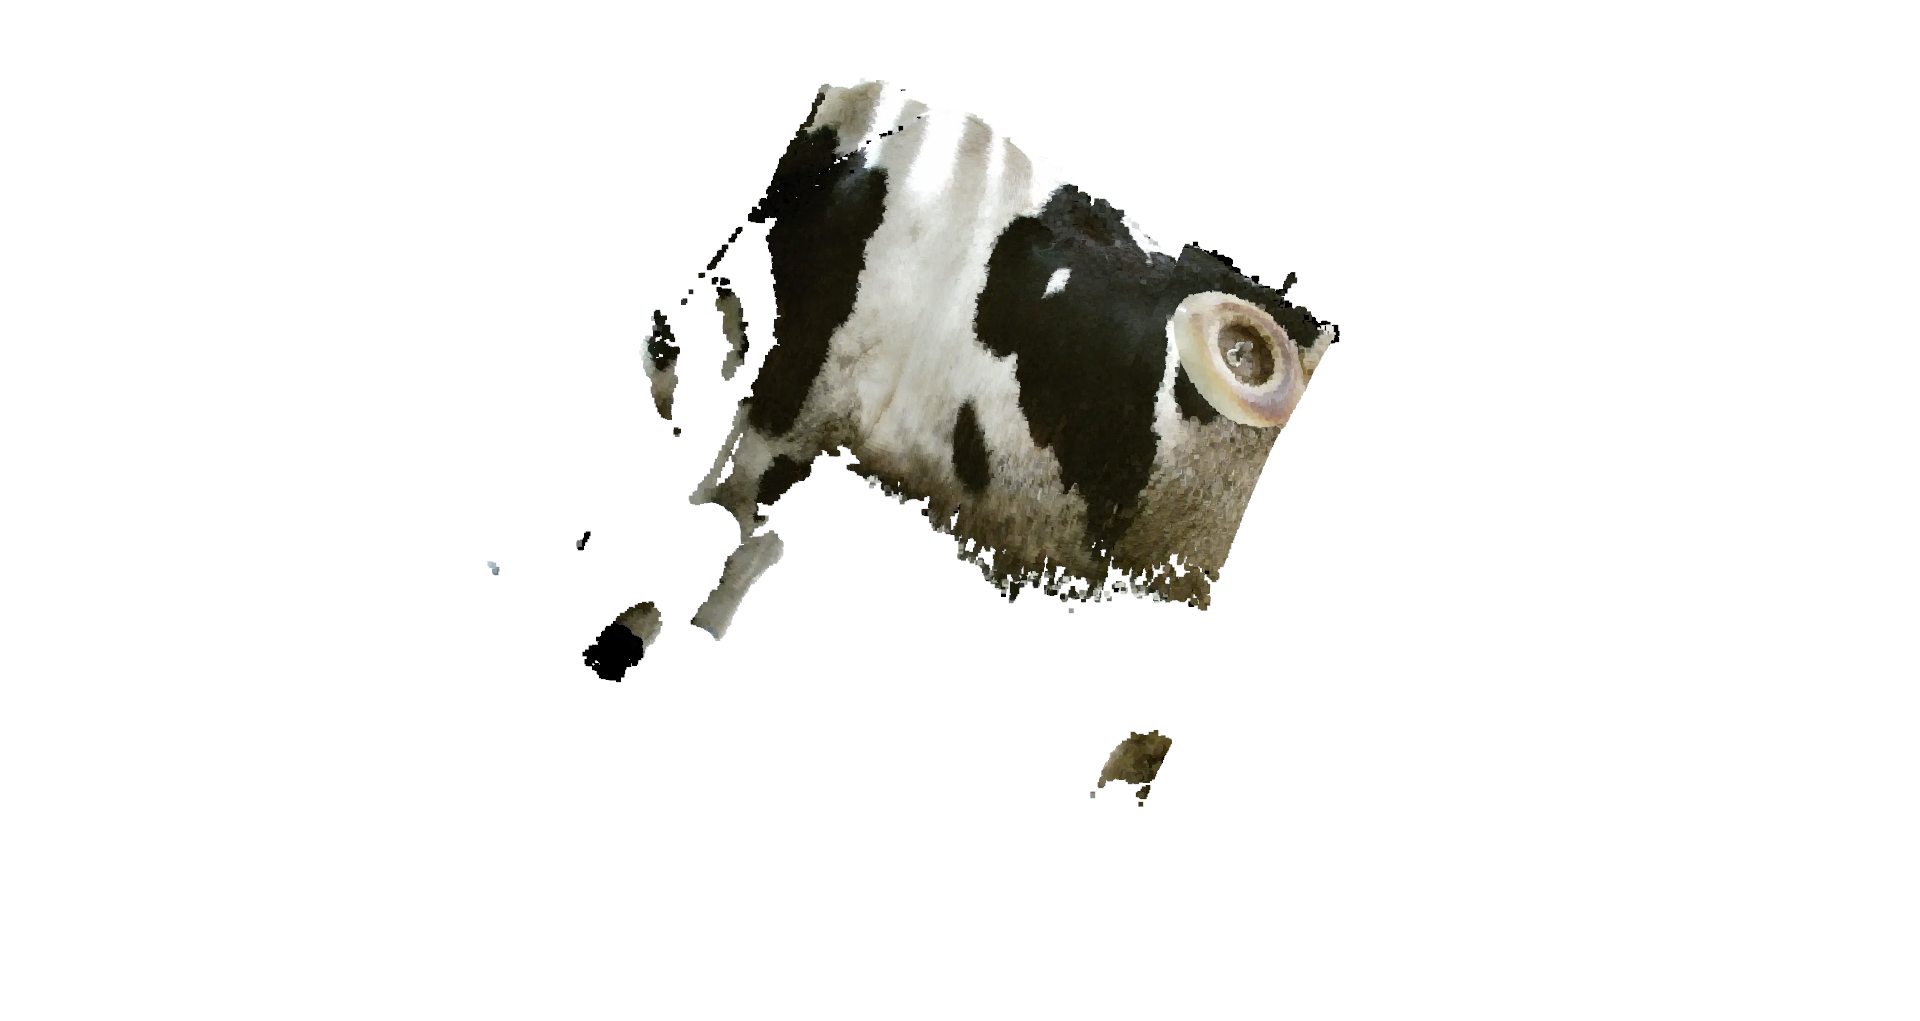

In [87]:
pcd_combined = o3d.geometry.PointCloud()
pcd_combined = sourceD+target_deformed
o3d.visualization.draw_geometries([sourceD,target_deformed])

In [17]:
def rot_x(theta):
    Rx = np.eye(4)
    Rx[0,:] = [1,0,0,0]
    Rx[1,:] = [0,np.cos(theta),-np.sin(theta),0]
    Rx[2,:] = [0,np.sin(theta),np.cos(theta),0]
    Rx[3,:] = [0,0,0,1]
    return Rx
    #[1 0 0 ; 0 ct,-st,0;st,ct]

In [24]:
# pick points from two point clouds and builds correspondences
picked_id_source = pick_points(source, exp_name, source_id)
picked_id_target = pick_points(target, exp_name, target_id)

assert (len(picked_id_source) >= 3 and len(picked_id_target) >= 3)
assert (len(picked_id_source) == len(picked_id_target))

# corr contains the correspondence points
# TO-DO: Save the correspondence points for future conveniences
corr = np.zeros((len(picked_id_source), 2))
corr[:, 0] = picked_id_source
corr[:, 1] = picked_id_target

# estimate rough transformation using correspondences
print("Compute a rough transform using the correspondences given by user")
p2p = o3d.pipelines.registration.TransformationEstimationPointToPoint()
trans_init = p2p.compute_transformation(source, target,
                                        o3d.utility.Vector2iVector(corr))
print(trans_init)


1) Please pick at least three correspondences using [shift + left click]
   Press [shift + right click] to undo point picking
2) After picking points, press 'Q' to close the window
[Open3D INFO] Picked point #44154 (-0.17, 0.17, 0.75) to add in queue.
[Open3D INFO] Picked point #32630 (-0.25, 0.031, 0.81) to add in queue.
[Open3D INFO] Picked point #120805 (0.26, -0.24, 0.9) to add in queue.


1) Please pick at least three correspondences using [shift + left click]
   Press [shift + right click] to undo point picking
2) After picking points, press 'Q' to close the window
[Open3D INFO] Picked point #158320 (0.54, -0.37, 0.8) to add in queue.
[Open3D INFO] Picked point #117309 (0.3, -0.35, 0.87) to add in queue.
[Open3D INFO] Picked point #61465 (-0.11, -0.32, 0.99) to add in queue.

Compute a rough transform using the correspondences given by user
[[-0.88133494  0.46902274 -0.05715233  0.24896825]
 [-0.33766173 -0.7098228  -0.61817162  0.13755548]
 [-0.33050457 -0.5255181   0.78396266 

In [6]:
# uses transformation from previous registration 
trans_init = np.loadtxt('/home/pupil/elitton/Cow_project/initialization/calibration/%s_transform.txt'% (exp_name), delimiter=',')

In [1]:
abs(-2)

2

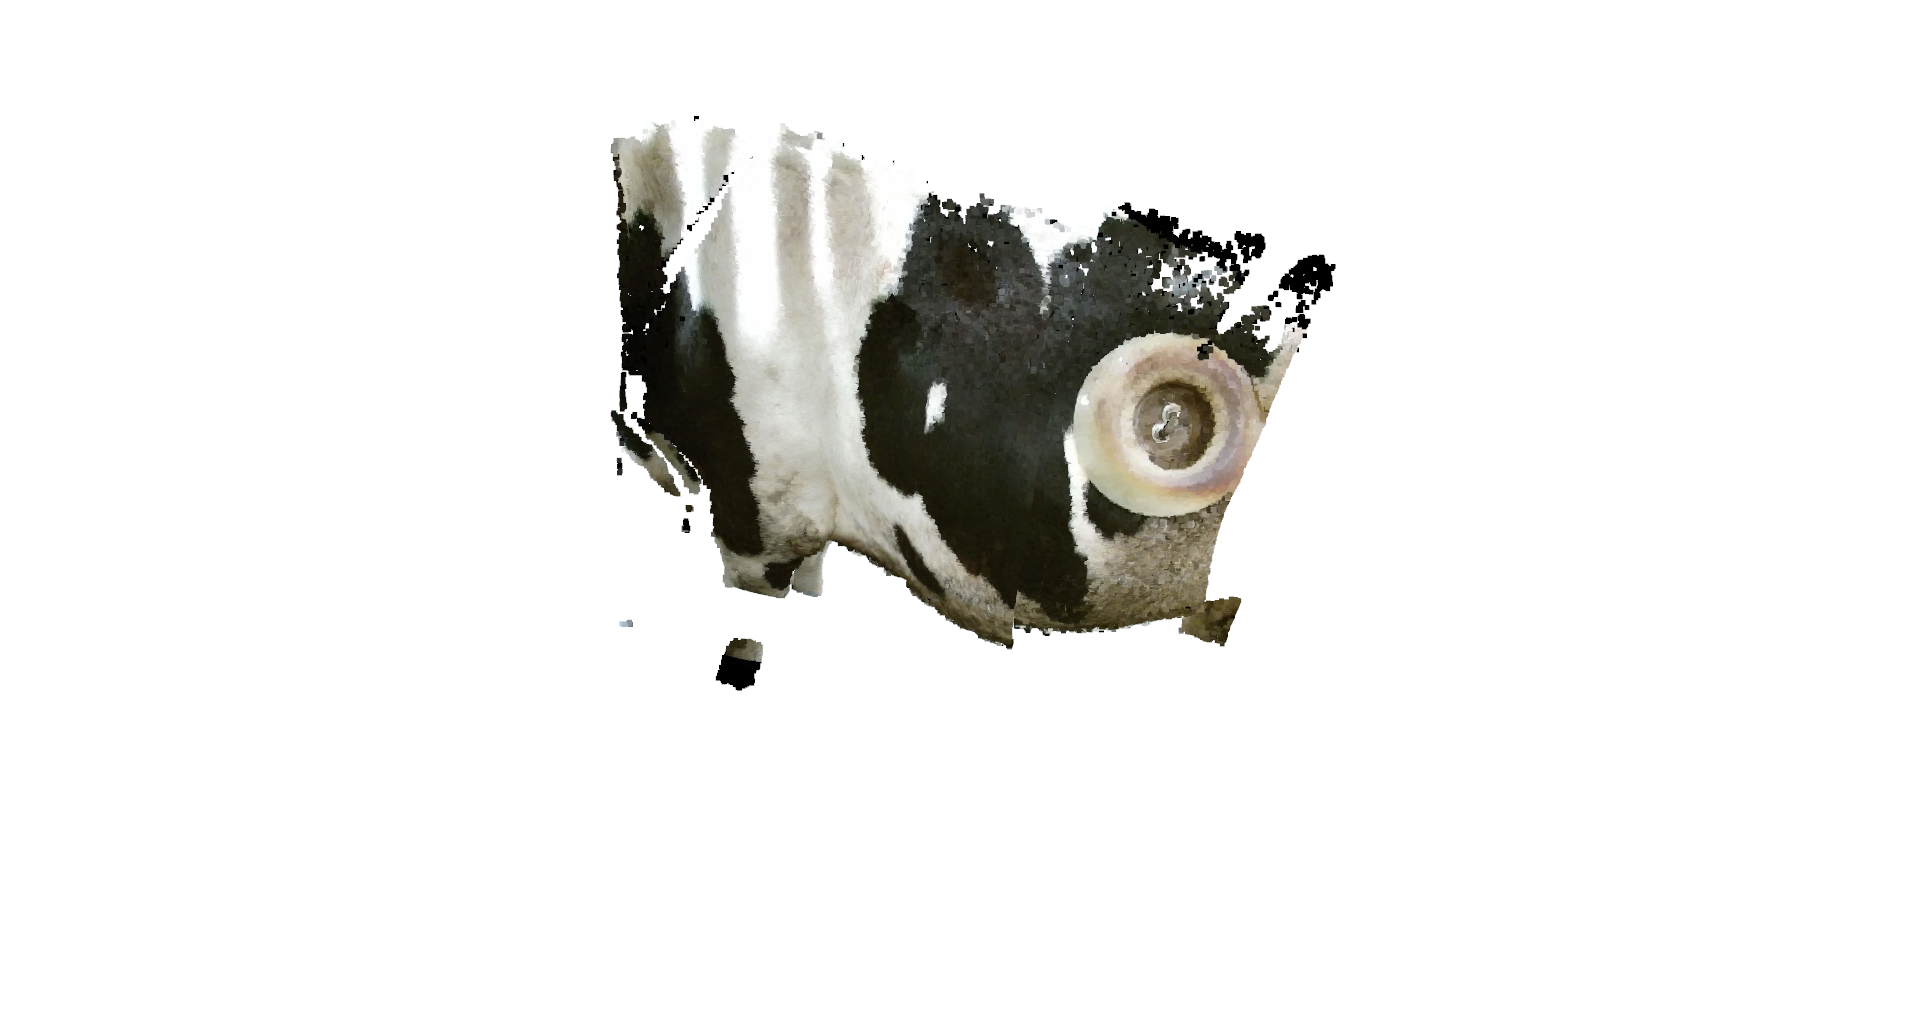

In [88]:
o3d.visualization.draw_geometries([pcd_combined])

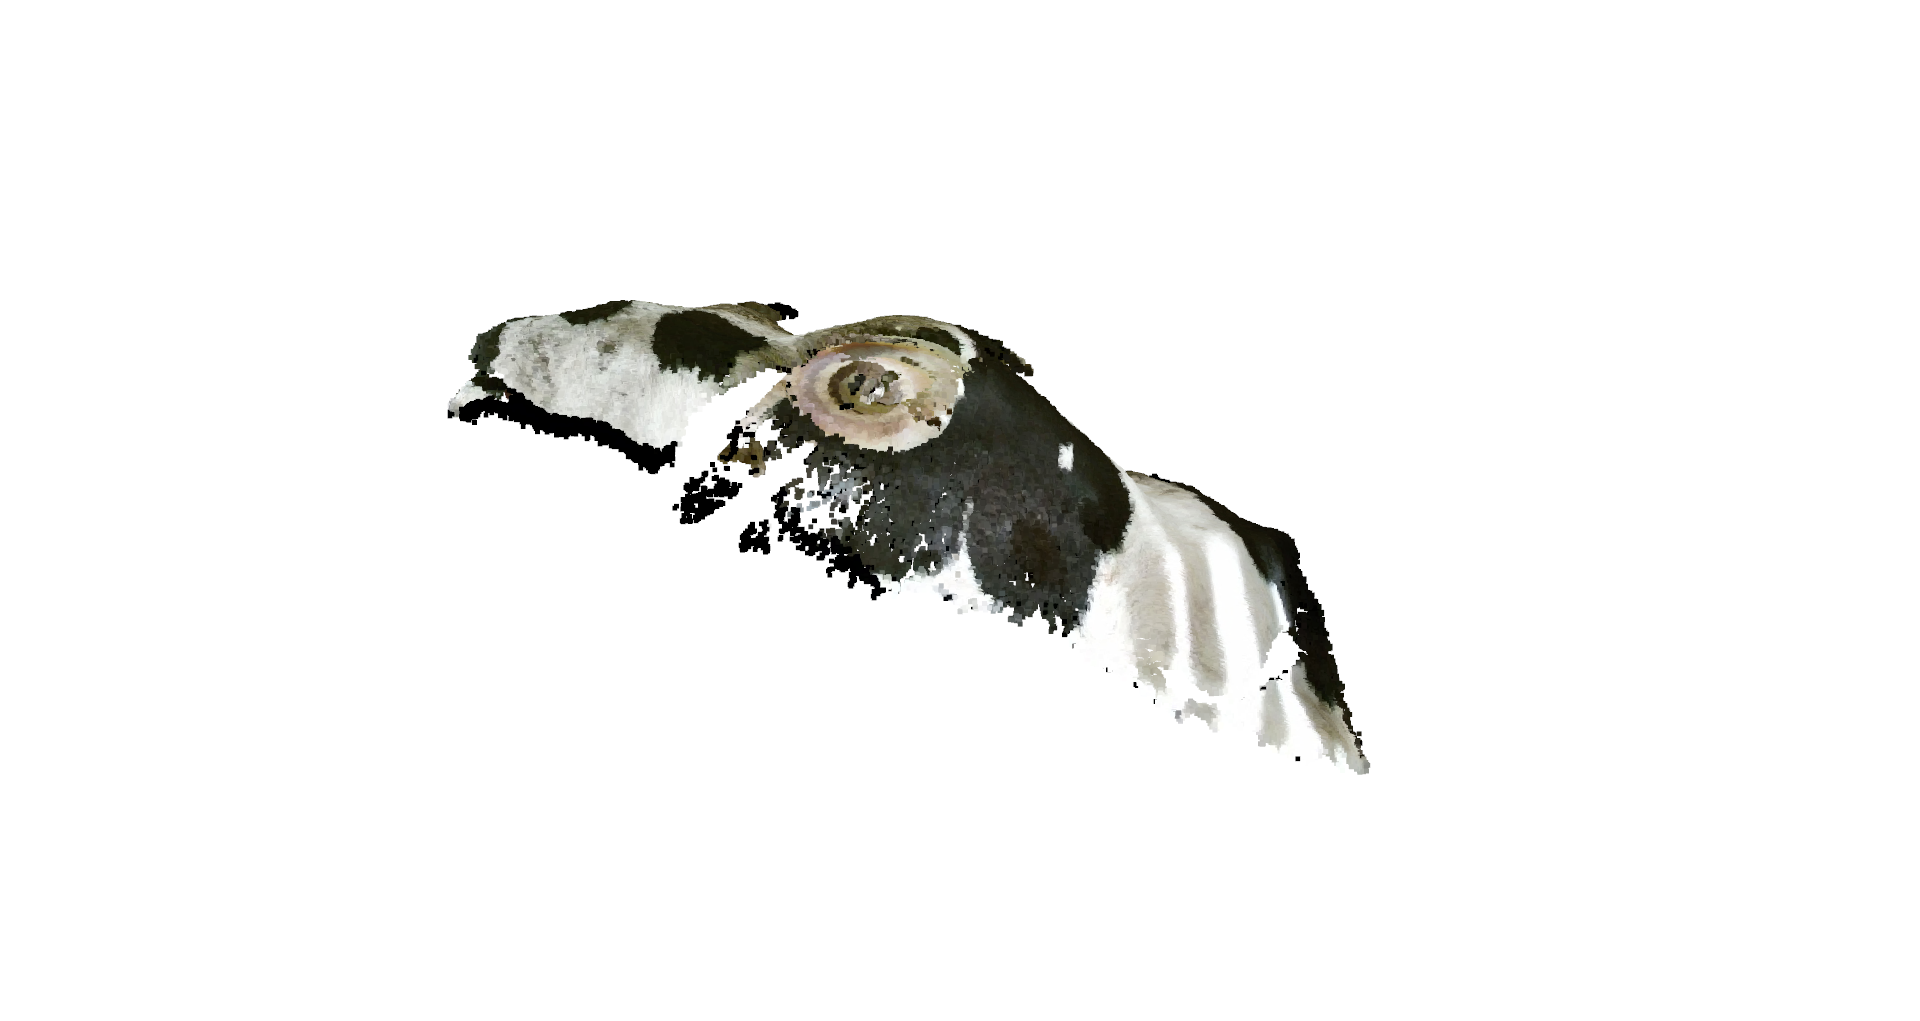

In [91]:
draw_registration_color(source,pcd_combined,trans_init)

In [64]:
# point-to-point ICP for refinement
print("Perform point-to-point ICP refinement")

threshold = 0.03 # 3cm distance threshold
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, pcd_combined, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p.transformation)

Perform point-to-point ICP refinement
[[ 9.85908448e-01 -1.22758213e-02 -1.66834756e-01  1.00999116e+00]
 [ 2.77550019e-04  9.97422545e-01 -7.17508887e-02  1.24264517e-01]
 [ 1.67285548e-01  7.06935024e-02  9.83370721e-01 -4.00337047e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


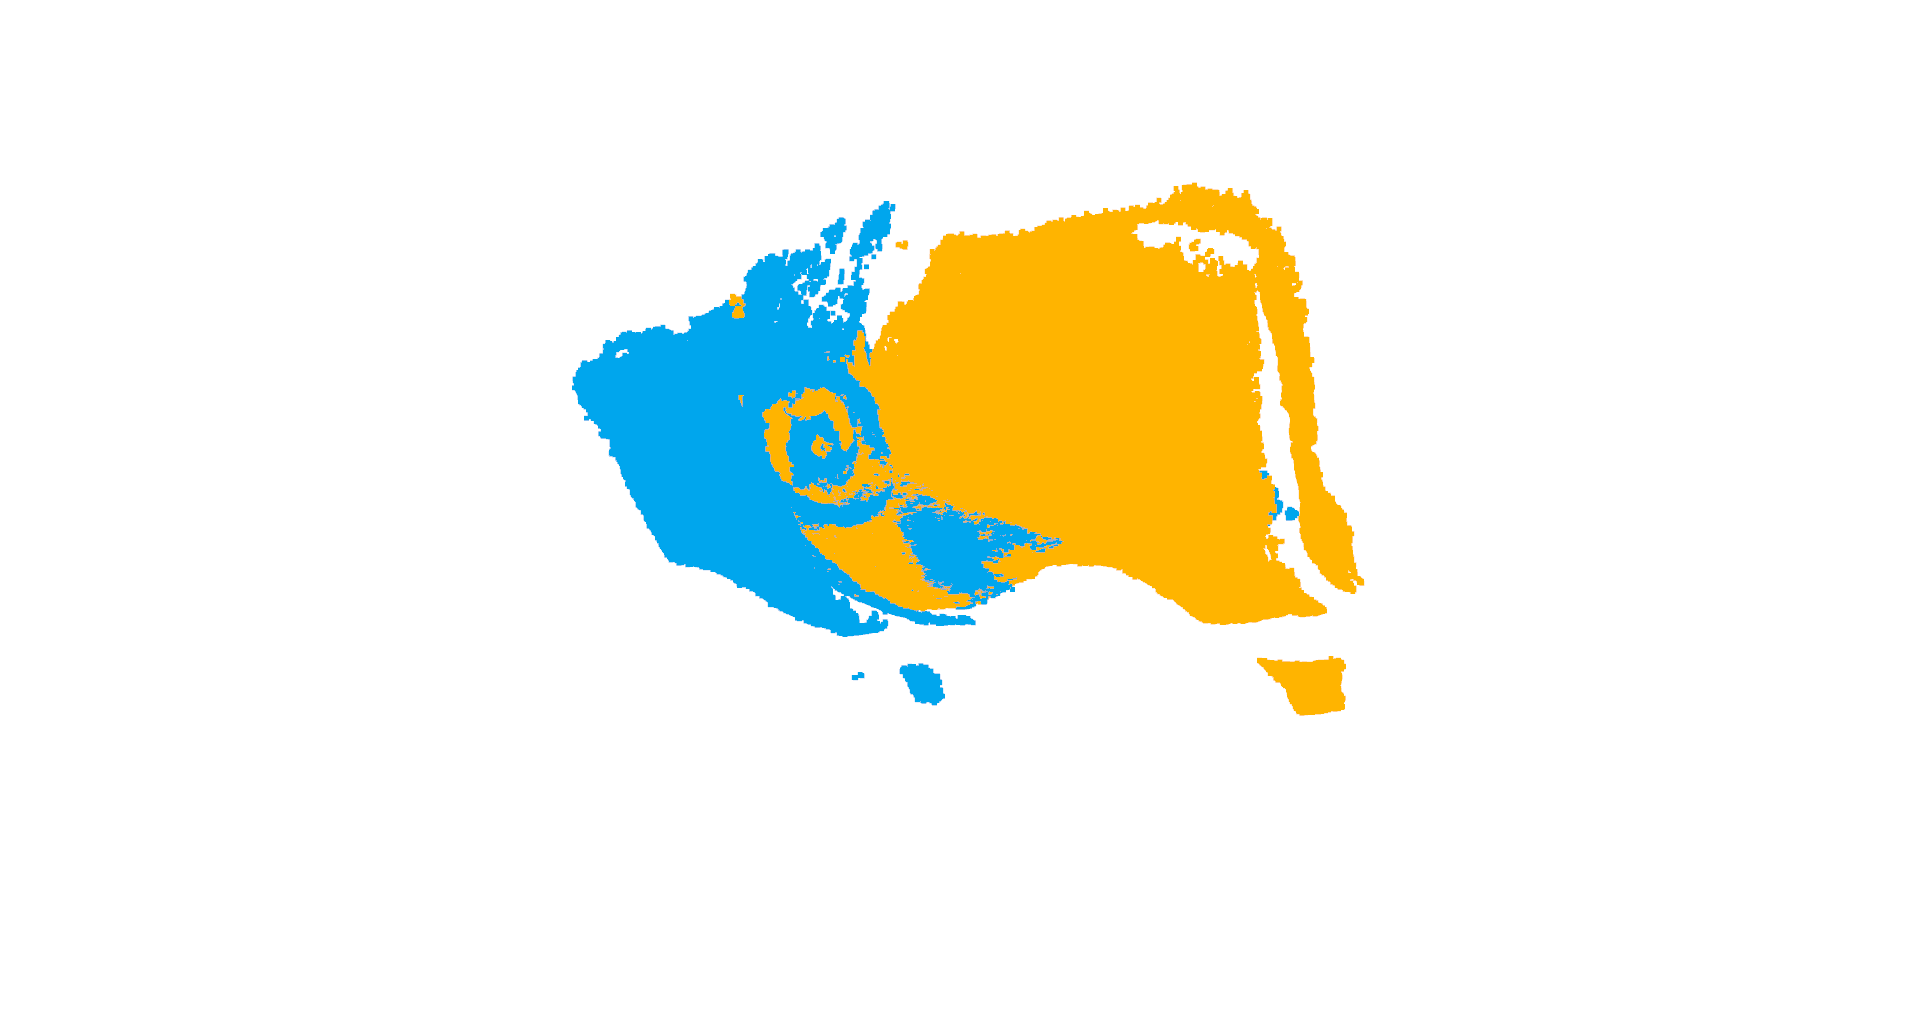

In [65]:
draw_registration_result(source,pcd_combined,reg_p2p.transformation)

In [66]:
reg_p2p.inlier_rmse


0.008994772100701135

In [19]:
type(correspondence)

open3d.cpu.pybind.utility.Vector2iVector

In [20]:
type(source)

open3d.cpu.pybind.geometry.PointCloud

In [21]:
type(target)

open3d.cpu.pybind.geometry.PointCloud

In [18]:
correspondence = reg_p2p.correspondence_set
rmse = o3d.pipelines.registration.TransformationEstimationPointToPoint.compute_rmse(source,target,correspondence)

TypeError: compute_rmse(): incompatible function arguments. The following argument types are supported:
    1. (self: open3d.cpu.pybind.pipelines.registration.TransformationEstimation, source: open3d.cpu.pybind.geometry.PointCloud, target: open3d.cpu.pybind.geometry.PointCloud, corres: open3d.cpu.pybind.utility.Vector2iVector) -> float

Invoked with: PointCloud with 95352 points., PointCloud with 120018 points., std::vector<Eigen::Vector2i> with 27688 elements.
Use numpy.asarray() to access data.

Did you forget to `#include <pybind11/stl.h>`? Or <pybind11/complex.h>,
<pybind11/functional.h>, <pybind11/chrono.h>, etc. Some automatic
conversions are optional and require extra headers to be included
when compiling your pybind11 module.

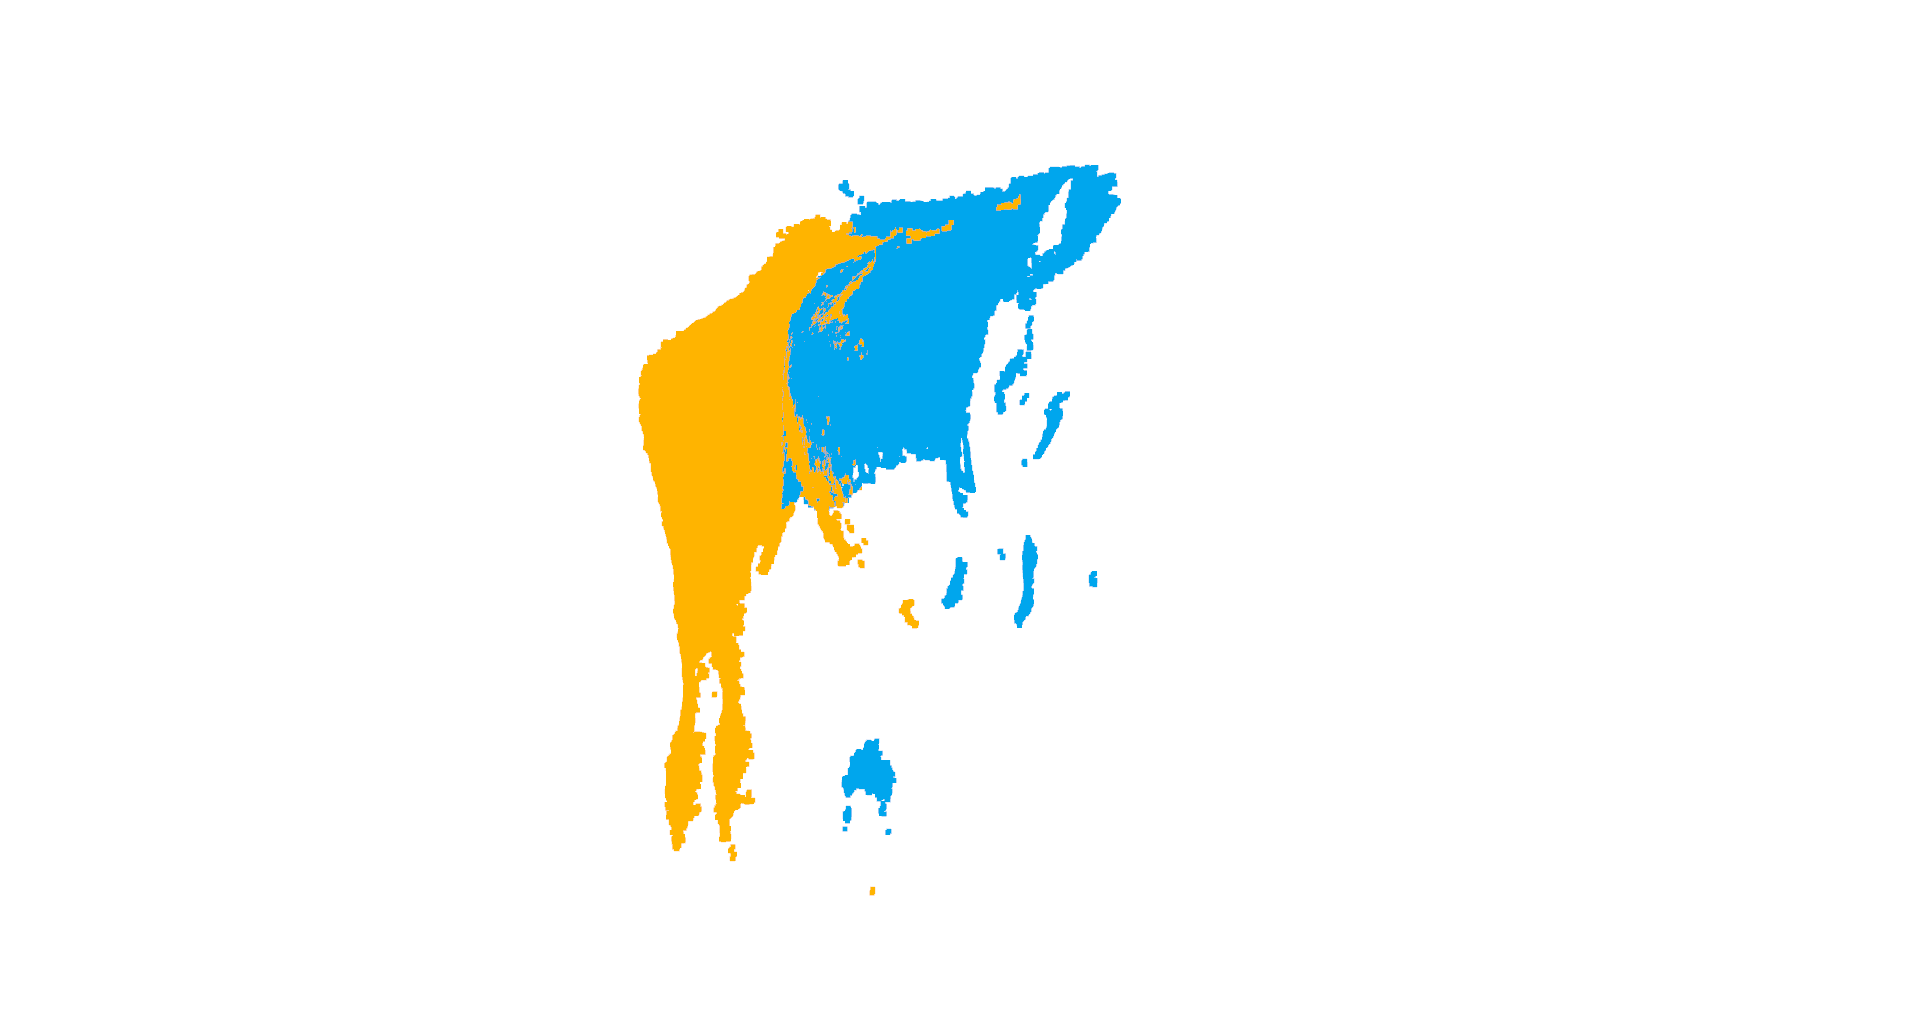

In [15]:
draw_registration_result(source,target,reg_p2p.transformation)

In [22]:
# pcds = []
# pcds.append(source)
# target.transform(inv(reg_p2p.transformation)) #transform the target pointcloud to the source coordinate frame
# pcds.append(target)
# cloud1_2 = merge_clouds(pcds)
# o3d.visualization.draw_geometries([cloud1_2])

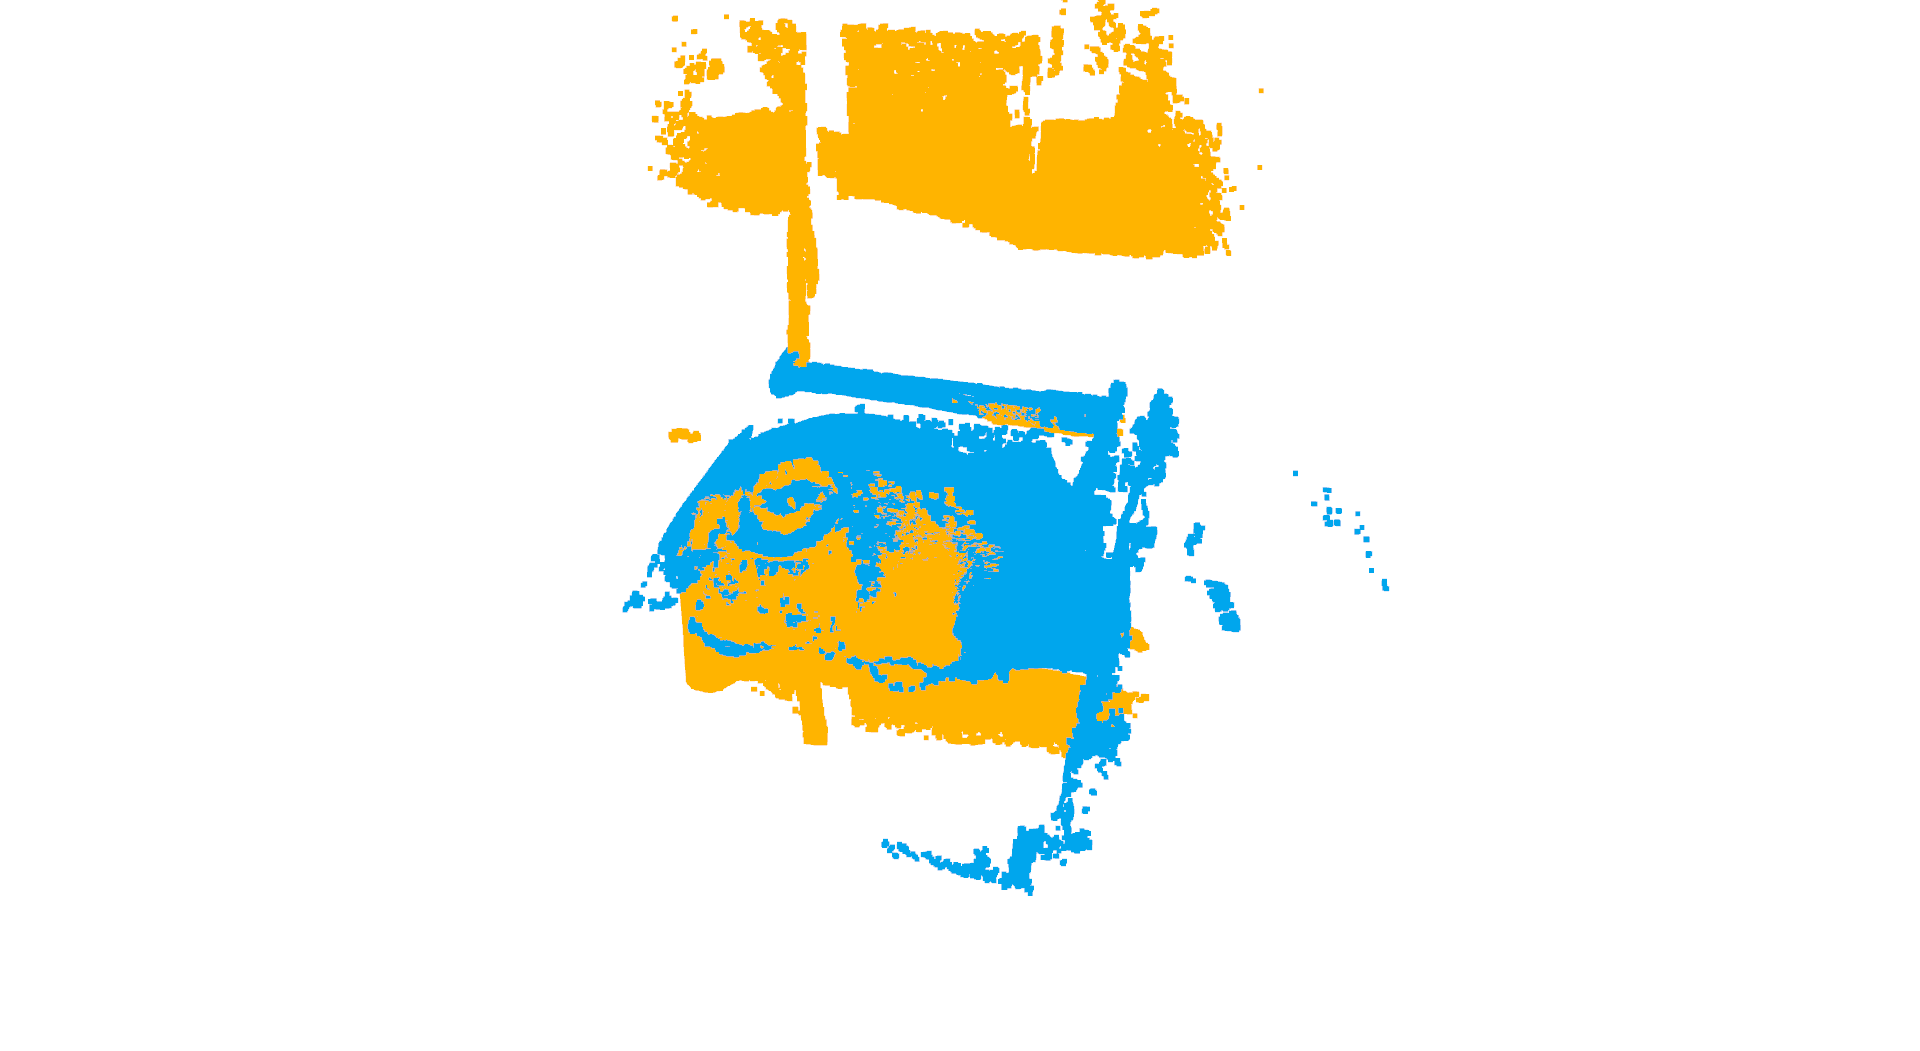

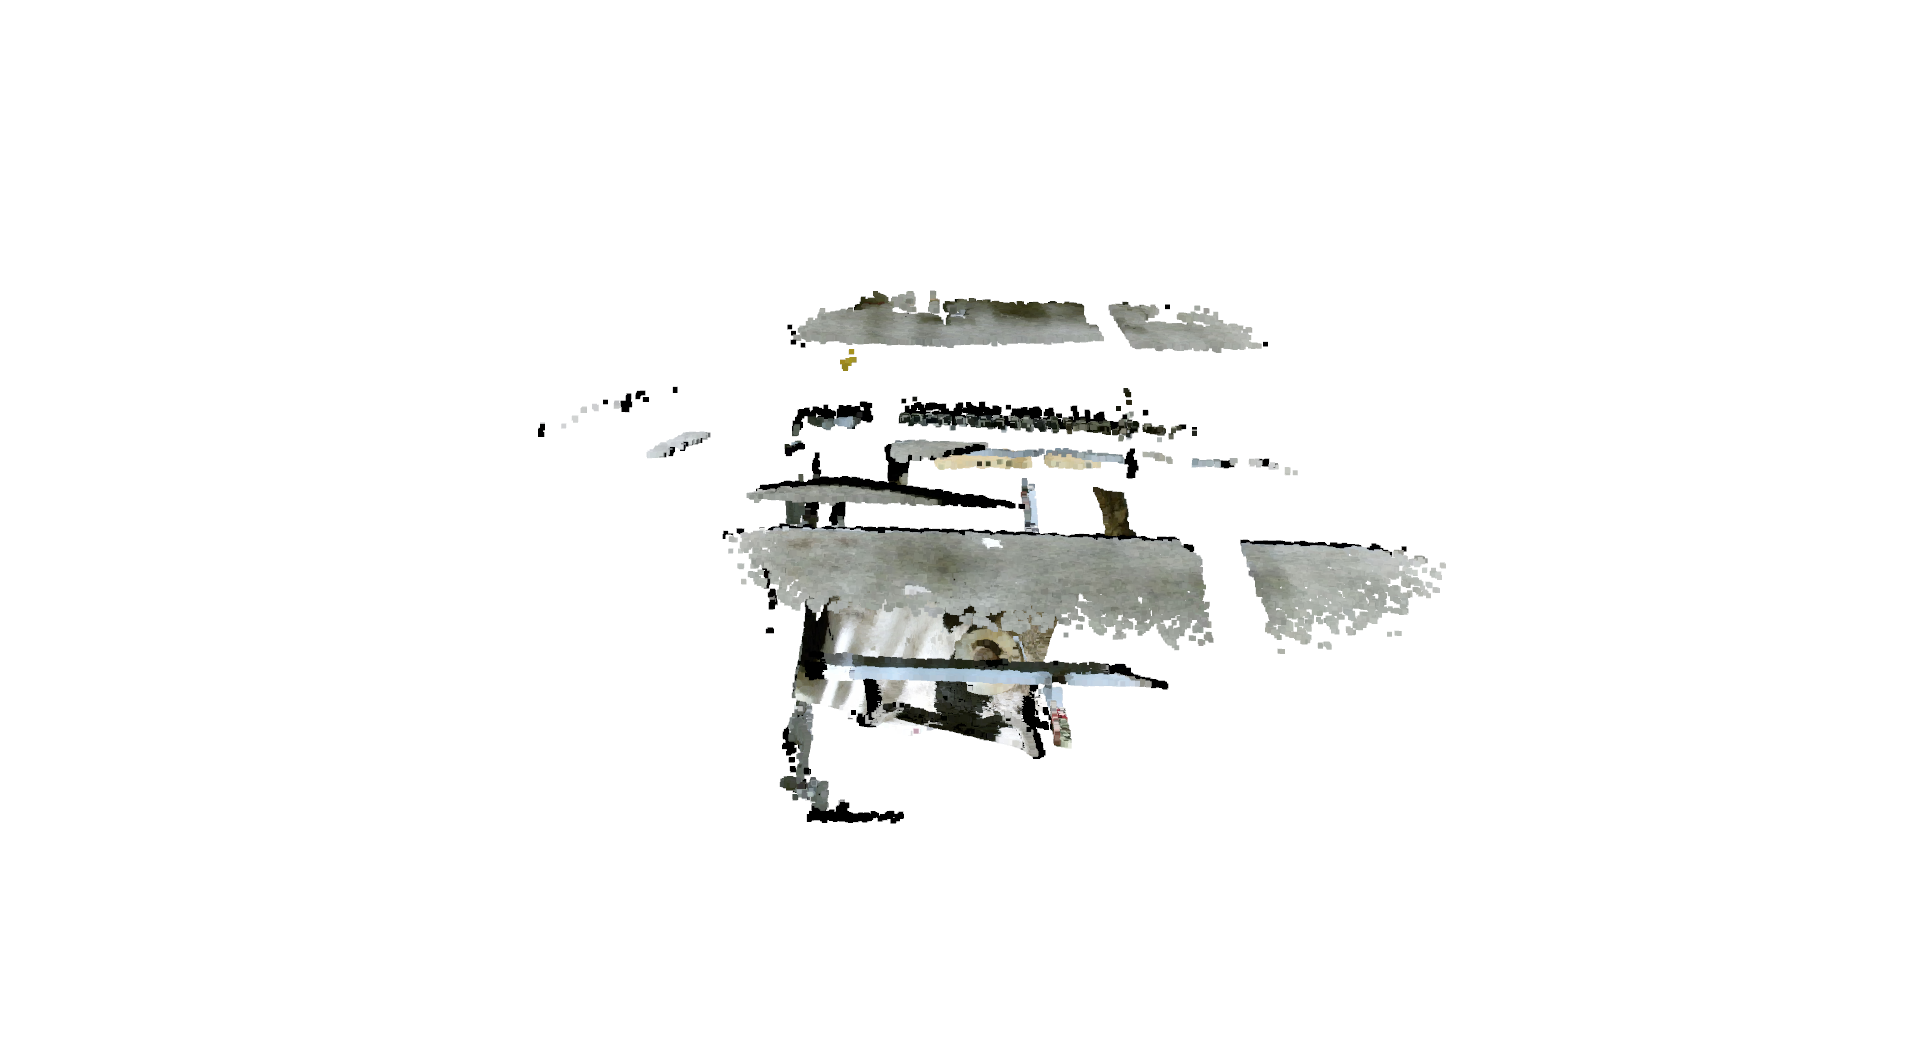

In [23]:
draw_registration_result(source, target, reg_p2p.transformation)
draw_registration_color(source, target, reg_p2p.transformation)
print("")

In [240]:
# Save the parameters
# np.savetxt('calibration/%s_corr.txt' % (exp_name), corr, delimiter=',')

np.savetxt('calibration/%s_transform.txt' % (exp_name), reg_p2p.transformation, delimiter=',')
# np.savetxt('/home/pupil/elitton/Cow_project/initialization/empty_calibration/%s_transform.txt' % (exp_name), reg_p2p.transformation, delimiter=',')


# Register all Point Clouds (Left, Right, Top)

In [314]:
# Load all point clouds

# filepath = '/home/pupil/elitton/Cow_project/empty_cage_images/all_plys_0001/'
source  = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 9))

left1   = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 1))
left2   = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 2))
left3   = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 3))
left4   = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 4))

right5 = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 5))
right6 = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 6))
right7 = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 7))
right8 = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 8))

# Load all transformations
H93 = np.loadtxt('calibration/top93_transform.txt', delimiter=',')
H95 = np.loadtxt('calibration/top95_transform.txt', delimiter=',')

H31 = np.loadtxt('calibration/left31_transform.txt', delimiter=',')
H34 = np.loadtxt('calibration/left34_transform.txt', delimiter=',')
H12 = np.loadtxt('calibration/left12_transform.txt', delimiter=',')

H56 = np.loadtxt('calibration/right56_transform.txt', delimiter=',')
H57 = np.loadtxt('calibration/right57_transform.txt', delimiter=',')
H78 = np.loadtxt('calibration/right78_transform.txt', delimiter=',')

# H93 = np.loadtxt('initialization/htms/top91_transform.txt', delimiter=',')
# H95 = np.loadtxt('initialization/htms/top95_transform.txt', delimiter=',')

# H12 = np.loadtxt('initialization/htms/left12_transform.txt', delimiter=',')
# H13 = np.loadtxt('initialization/htms/left13_transform.txt', delimiter=',')
# H34 = np.loadtxt('initialization/htms/left34_transform.txt', delimiter=',')

# H56 = np.loadtxt('initialization/htms/right56_transform.txt', delimiter=',')
# H57 = np.loadtxt('initialization/htms/right57_transform.txt', delimiter=',')
# H78 = np.loadtxt('initialization/htms/right78_transform.txt', delimiter=',')

## Register only the left side

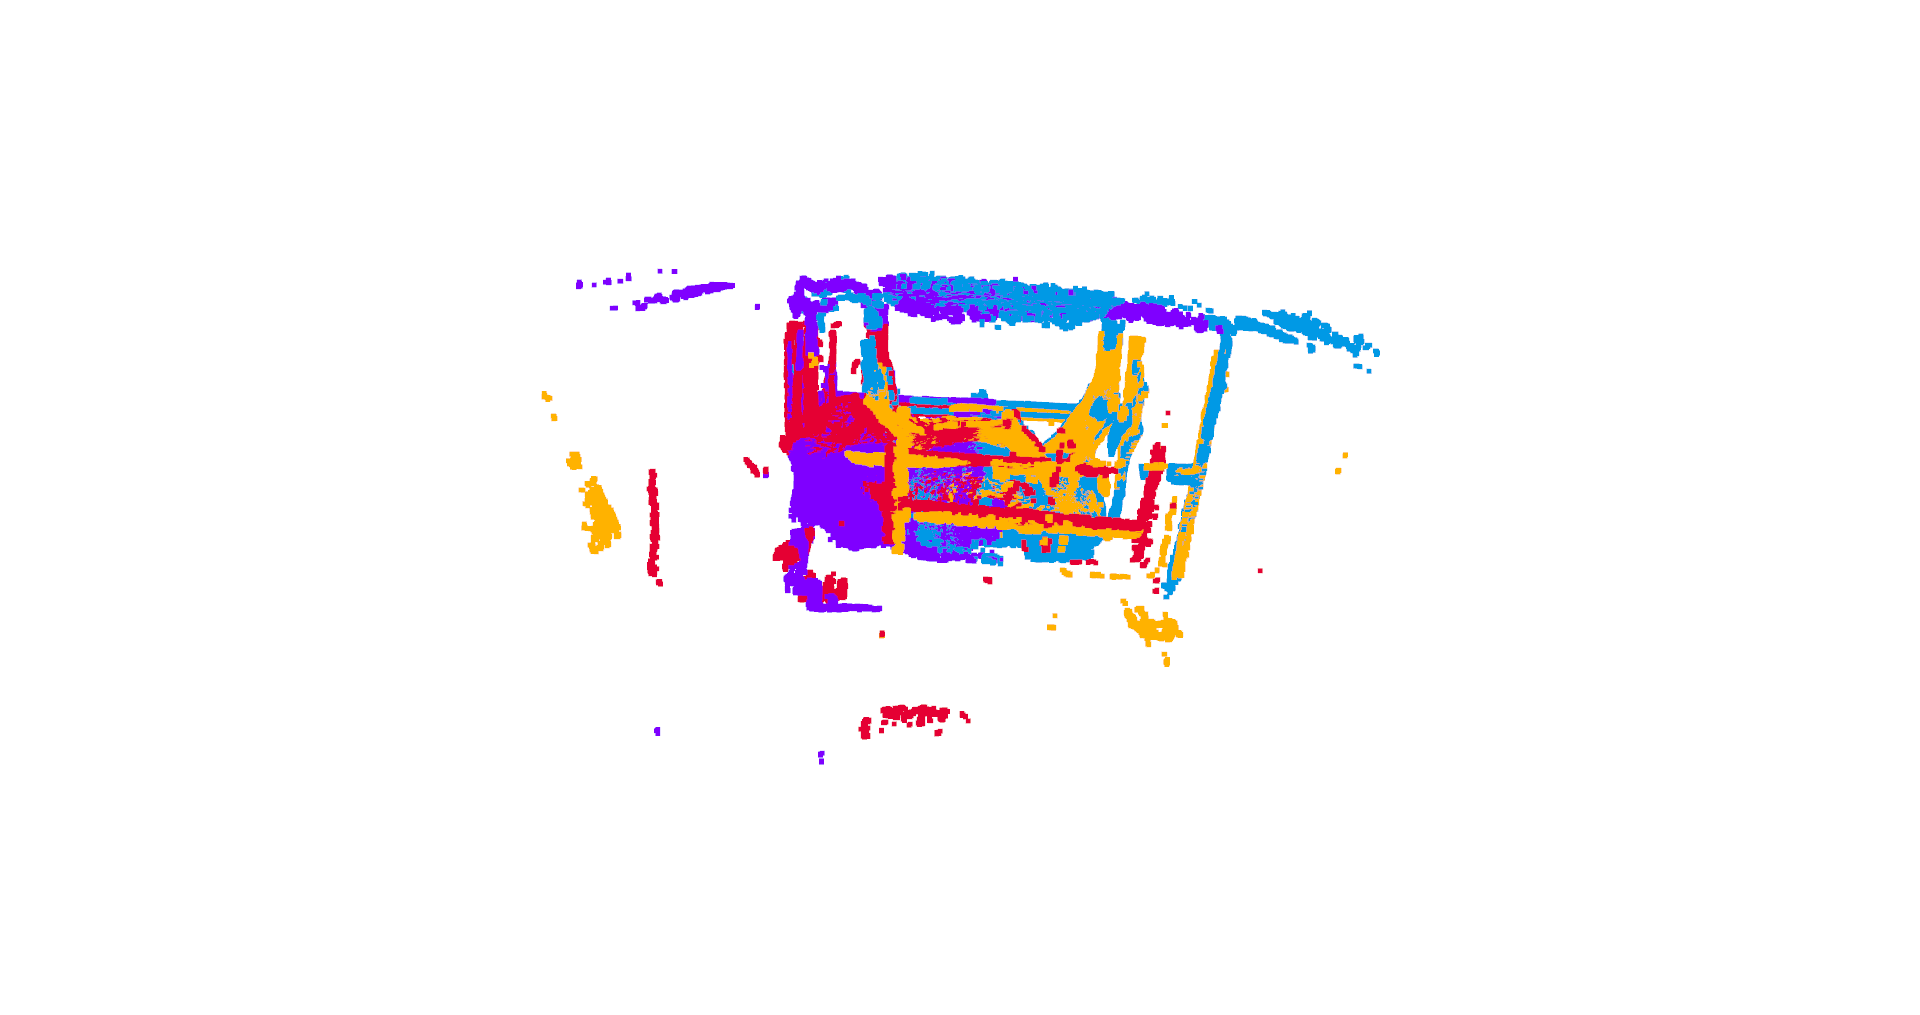

In [315]:
left1_temp = copy.deepcopy(left1)
left2_temp = copy.deepcopy(left2)
left3_temp = copy.deepcopy(left3)
left4_temp = copy.deepcopy(left4)

left1_temp.paint_uniform_color([0, 0.6, 0.9])
left2_temp.paint_uniform_color([1, 0.7, 0])
left3_temp.paint_uniform_color([0.5, 0, 1])
left4_temp.paint_uniform_color([0.9, 0, 0.2])

left1_temp.transform(inv(H31))
left4_temp.transform(inv(H34))
left2_temp.transform(inv(H31) @ inv(H12))



o3d.visualization.draw_geometries([left1_temp, left2_temp, left3_temp, left4_temp])

## Register only right side

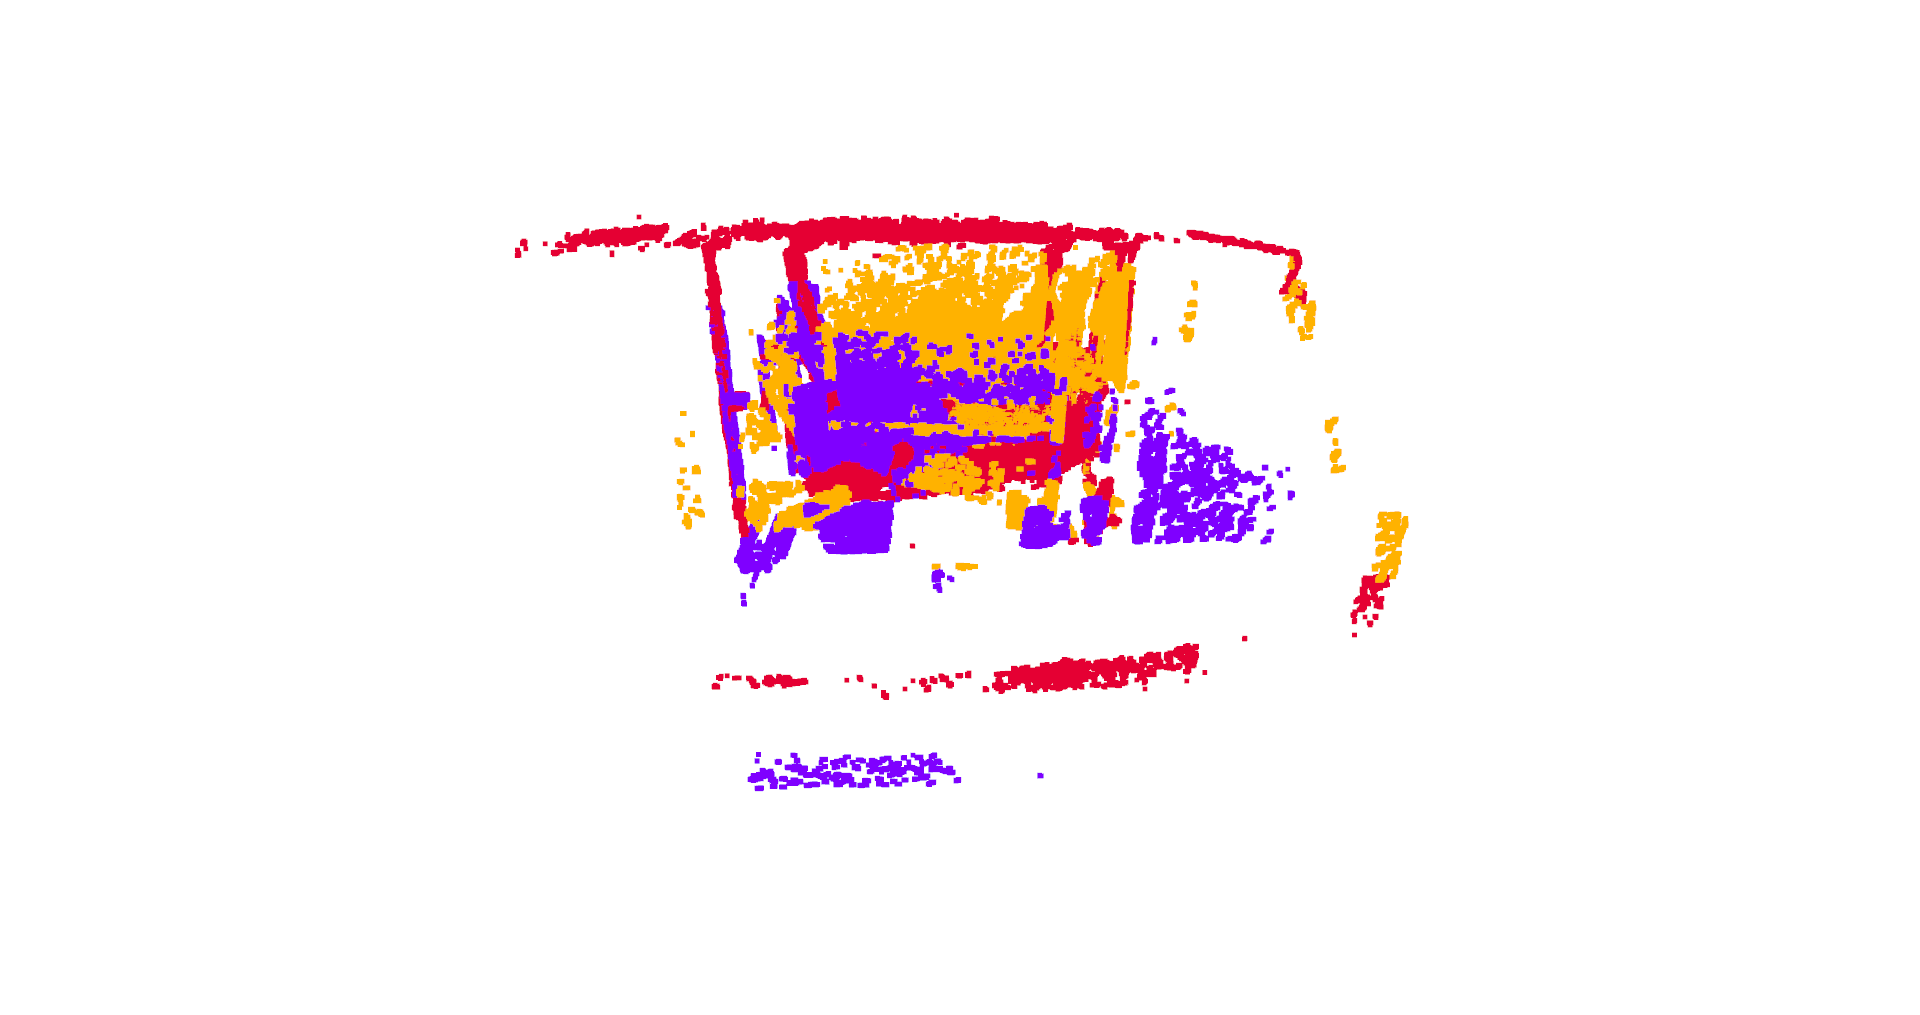

In [316]:
right5_temp = copy.deepcopy(right5)
right6_temp = copy.deepcopy(right6)
right7_temp = copy.deepcopy(right7)
right8_temp = copy.deepcopy(right8)

right5_temp.paint_uniform_color([0.9, 0, 0.2])
right6_temp.paint_uniform_color([1, 0.7, 0])
right7_temp.paint_uniform_color([0.9, 0, 0.2])
right8_temp.paint_uniform_color([0.5, 0, 1])

right6_temp.transform(inv(H56))
right7_temp.transform(inv(H57))
right8_temp.transform(inv(H57) @ inv(H78))

o3d.visualization.draw_geometries([right5_temp, right6_temp, right7_temp, right8_temp])

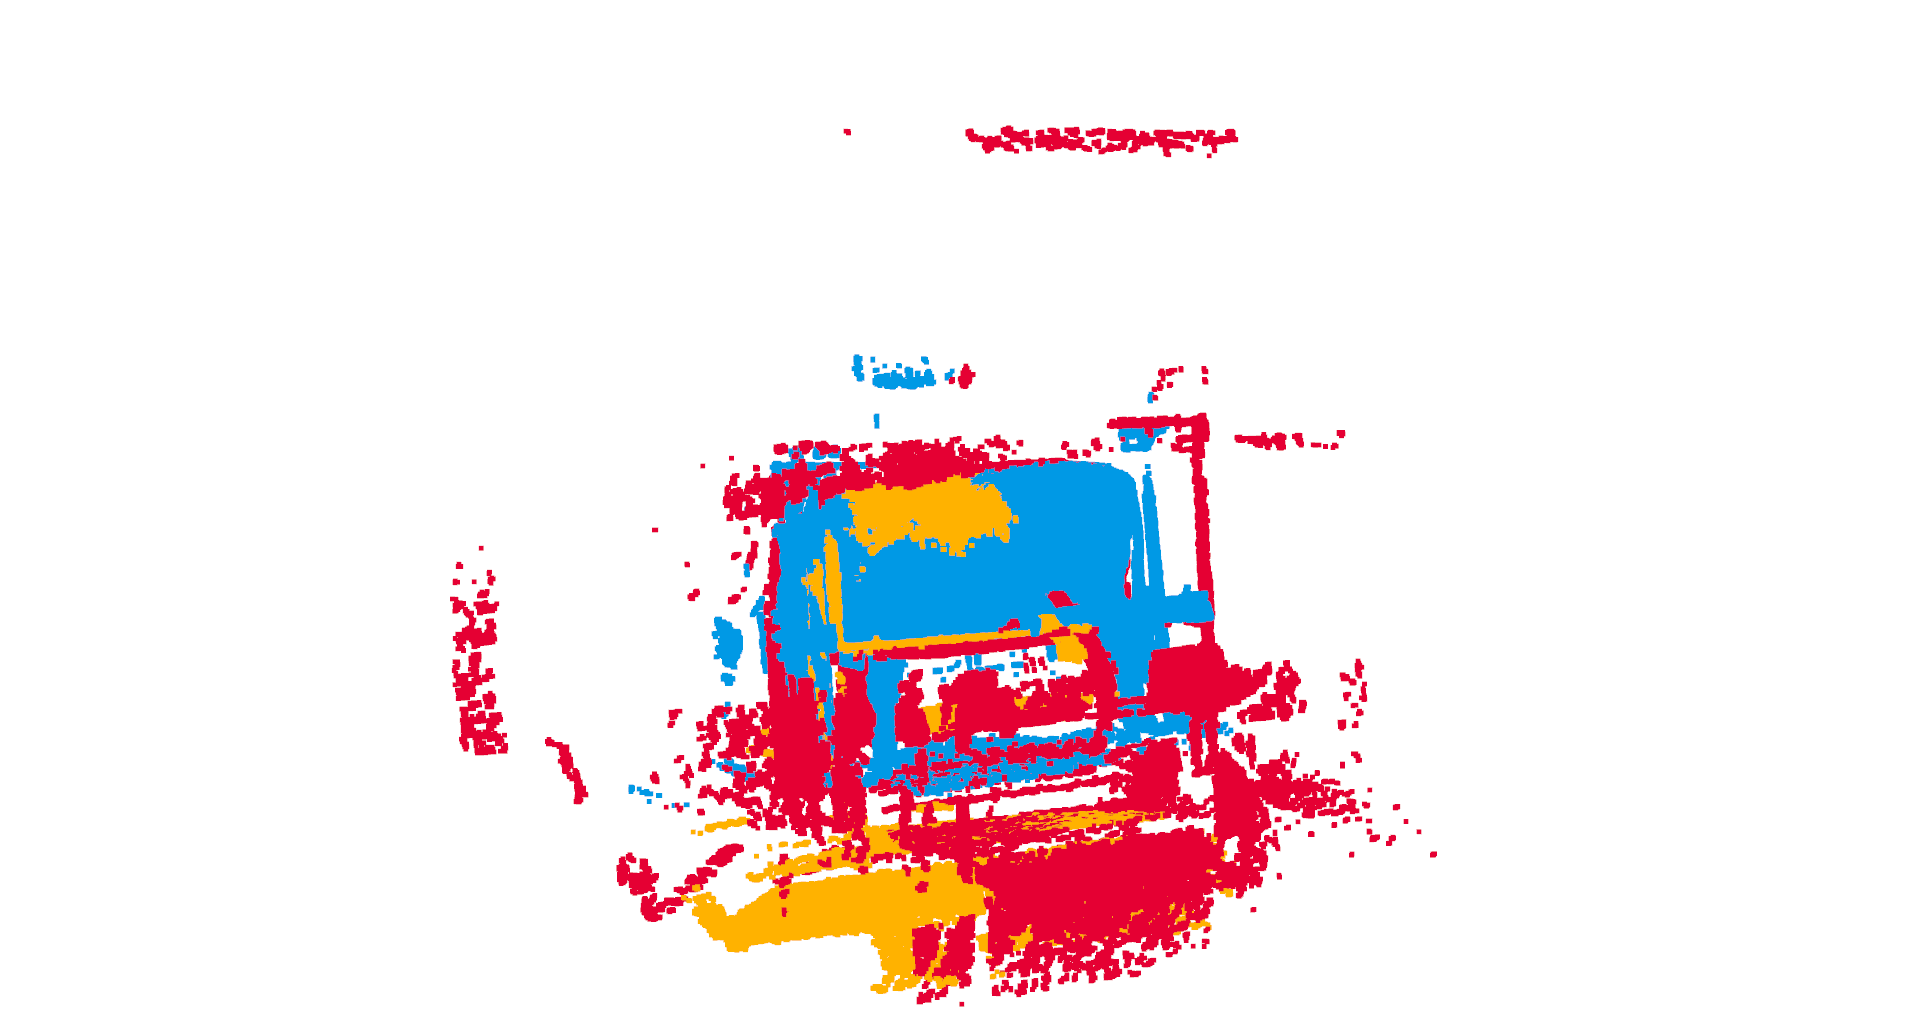

In [317]:
# Register with colored point clouds
source_temp = copy.deepcopy(source)

left1_temp = copy.deepcopy(left1)
left2_temp = copy.deepcopy(left2)
left3_temp = copy.deepcopy(left3)
left4_temp = copy.deepcopy(left4)

right5_temp = copy.deepcopy(right5)
right6_temp = copy.deepcopy(right6)
right7_temp = copy.deepcopy(right7)
right8_temp = copy.deepcopy(right8)

source_temp.paint_uniform_color([1, 0.7, 0])

left1_temp.paint_uniform_color([0, 0.6, 0.9])
left2_temp.paint_uniform_color([0, 0.6, 0.9])
left3_temp.paint_uniform_color([0, 0.6, 0.9])
left4_temp.paint_uniform_color([0, 0.6, 0.9])

right5_temp.paint_uniform_color([0.9, 0, 0.2])
right6_temp.paint_uniform_color([0.9, 0, 0.2])
right7_temp.paint_uniform_color([0.9, 0, 0.2])
right8_temp.paint_uniform_color([0.9, 0, 0.2])

# target3_temp.paint_uniform_color([0.5, 0, 1])

left3_temp.transform(inv(H93))
left1_temp.transform(inv(H93) @ inv(H31))
left4_temp.transform(inv(H93) @ inv(H34))
left2_temp.transform(inv(H93) @ inv(H31) @ inv(H12))



right5_temp.transform(inv(H95))
right6_temp.transform(inv(H95) @ inv(H56))
right7_temp.transform(inv(H95) @ inv(H57))
right8_temp.transform(inv(H95) @ inv(H57) @ inv(H78))

o3d.visualization.draw_geometries([source_temp, 
                                   left1_temp, left2_temp, left3_temp, left4_temp,
                                   right5_temp, right6_temp, right7_temp, right8_temp])

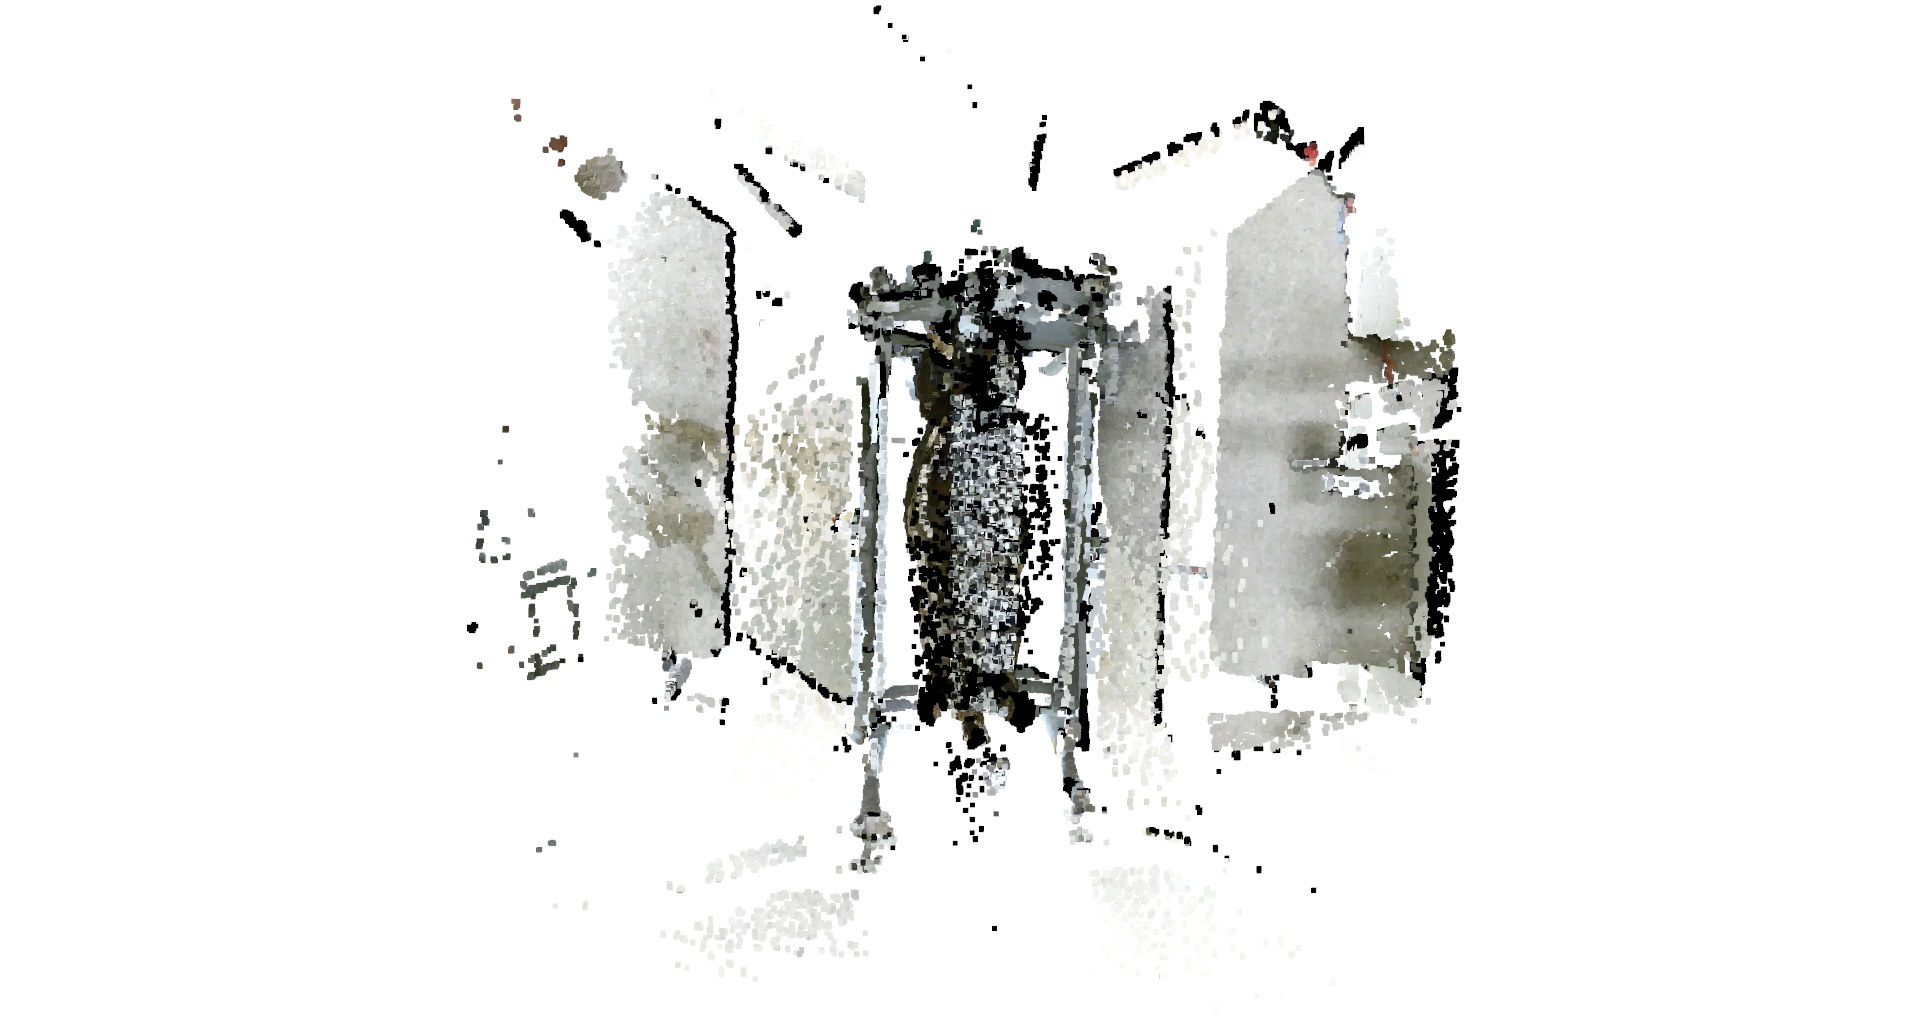

In [318]:
# Register with original point clouds
source_temp = copy.deepcopy(source)

left1_temp = copy.deepcopy(left1)
left2_temp = copy.deepcopy(left2)
left3_temp = copy.deepcopy(left3)
left4_temp = copy.deepcopy(left4)

right5_temp = copy.deepcopy(right5)
right6_temp = copy.deepcopy(right6)
right7_temp = copy.deepcopy(right7)
right8_temp = copy.deepcopy(right8)

left3_temp.transform(inv(H93))
left1_temp.transform(inv(H93) @ inv(H31))
left4_temp.transform(inv(H93) @ inv(H34))
left2_temp.transform(inv(H93) @ inv(H31) @ inv(H12))

right5_temp.transform(inv(H95))
right6_temp.transform(inv(H95) @ inv(H56))
right7_temp.transform(inv(H95) @ inv(H57))
right8_temp.transform(inv(H95) @ inv(H57) @ inv(H78))

o3d.visualization.draw_geometries([source_temp, 
                                   left1_temp, left2_temp, left3_temp, left4_temp,
                                   right5_temp, right6_temp, right7_temp, right8_temp])

In [319]:
pcd = o3d.geometry.PointCloud()
pcd = source_temp + left1_temp + left2_temp + left3_temp + left4_temp + right5_temp + right6_temp + right7_temp + right8_temp

In [320]:
def merge_clouds(clouds):
    resulting_cloud = o3d.geometry.PointCloud()
    for i in range(len(clouds)):
        resulting_cloud += clouds[i]
    return resulting_cloud

def save_pcd(pcd,name):
    if (o3d.io.write_point_cloud(name, pcd) ):
        print('Success')
    else :
        print('Failed')

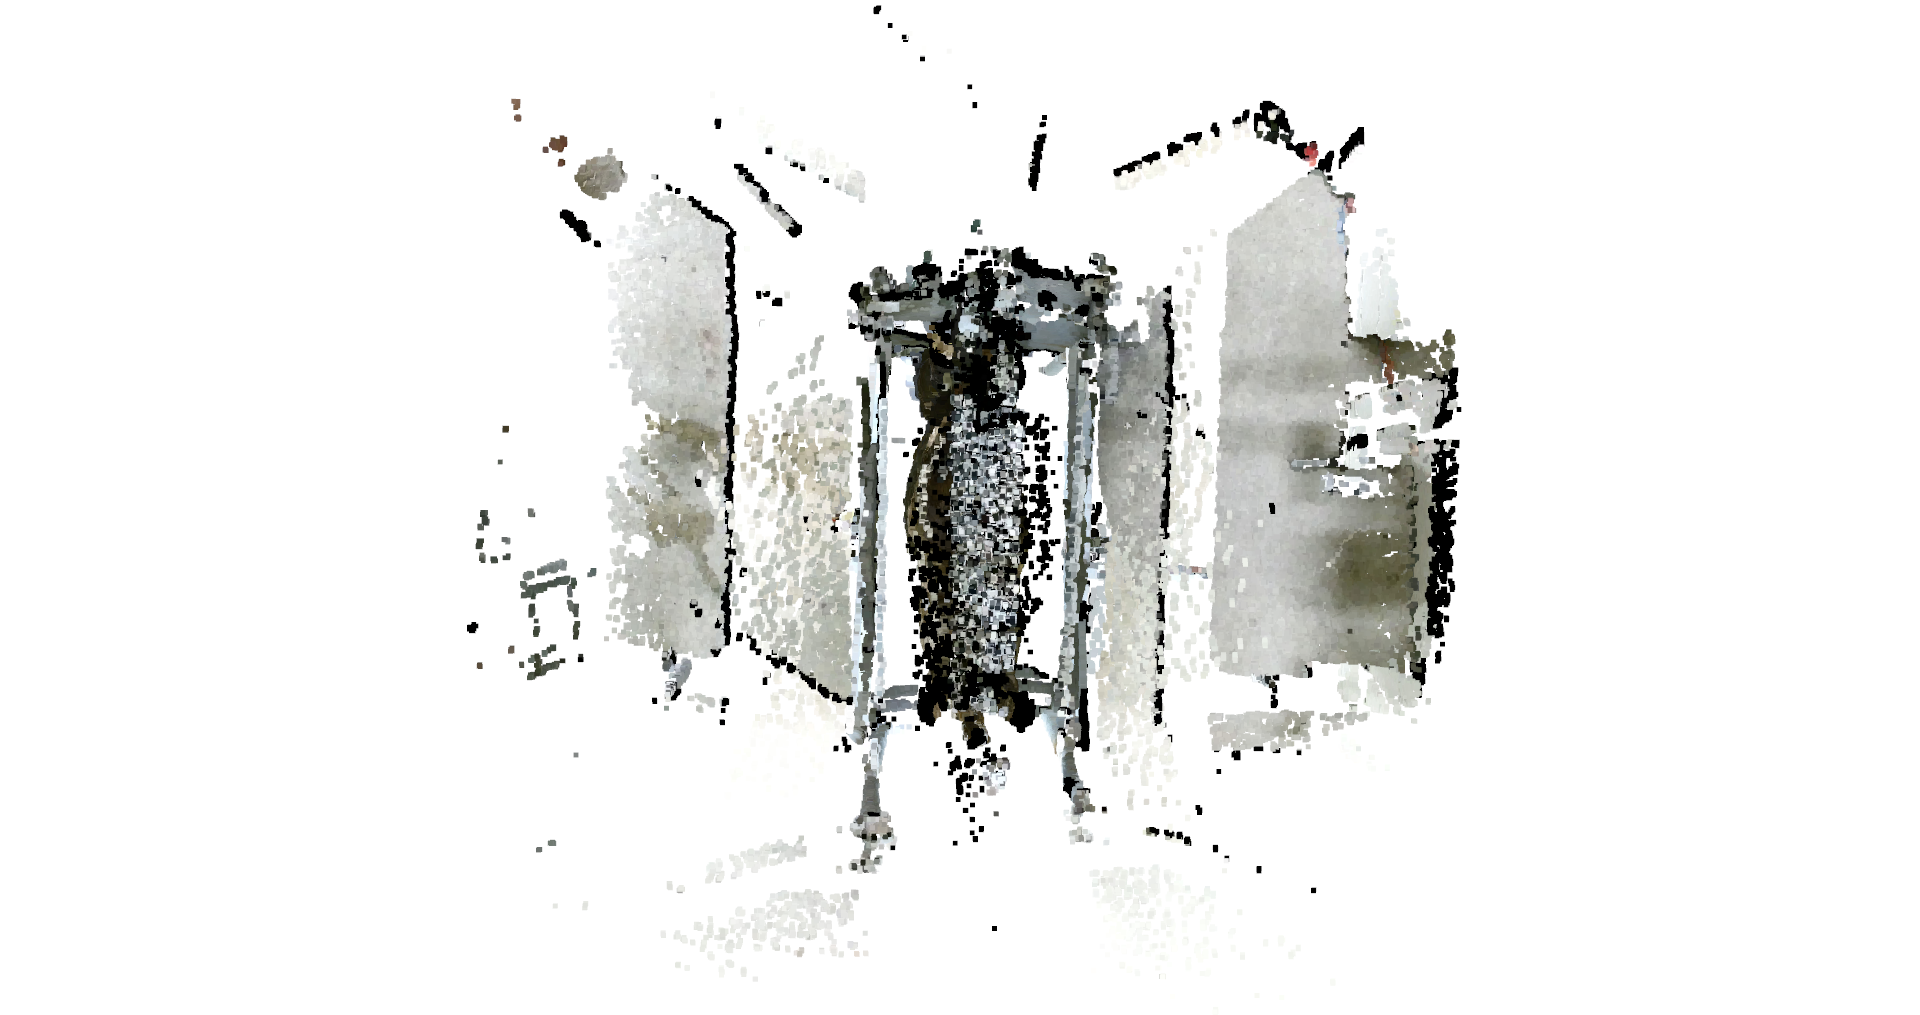

In [321]:
o3d.visualization.draw_geometries([pcd]) 

In [322]:
left1_temp.points

std::vector<Eigen::Vector3d> with 130464 elements.
Use numpy.asarray() to access data.

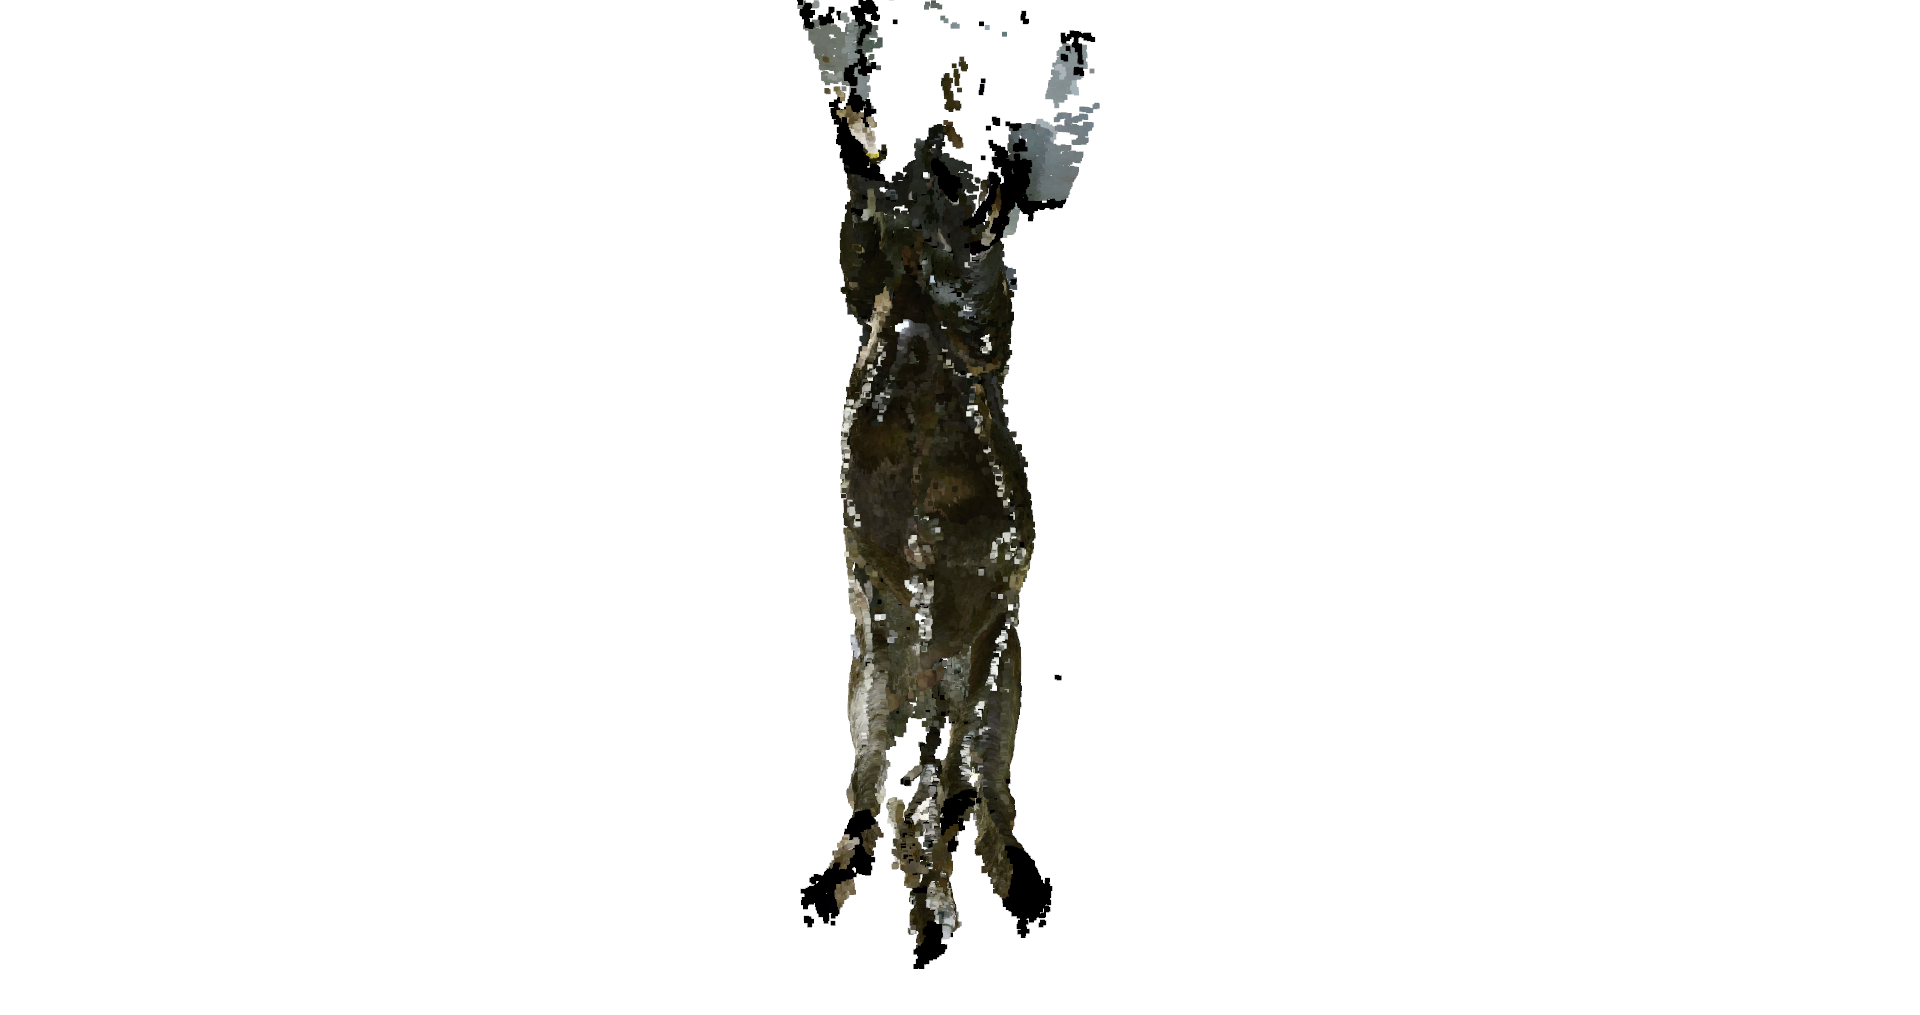

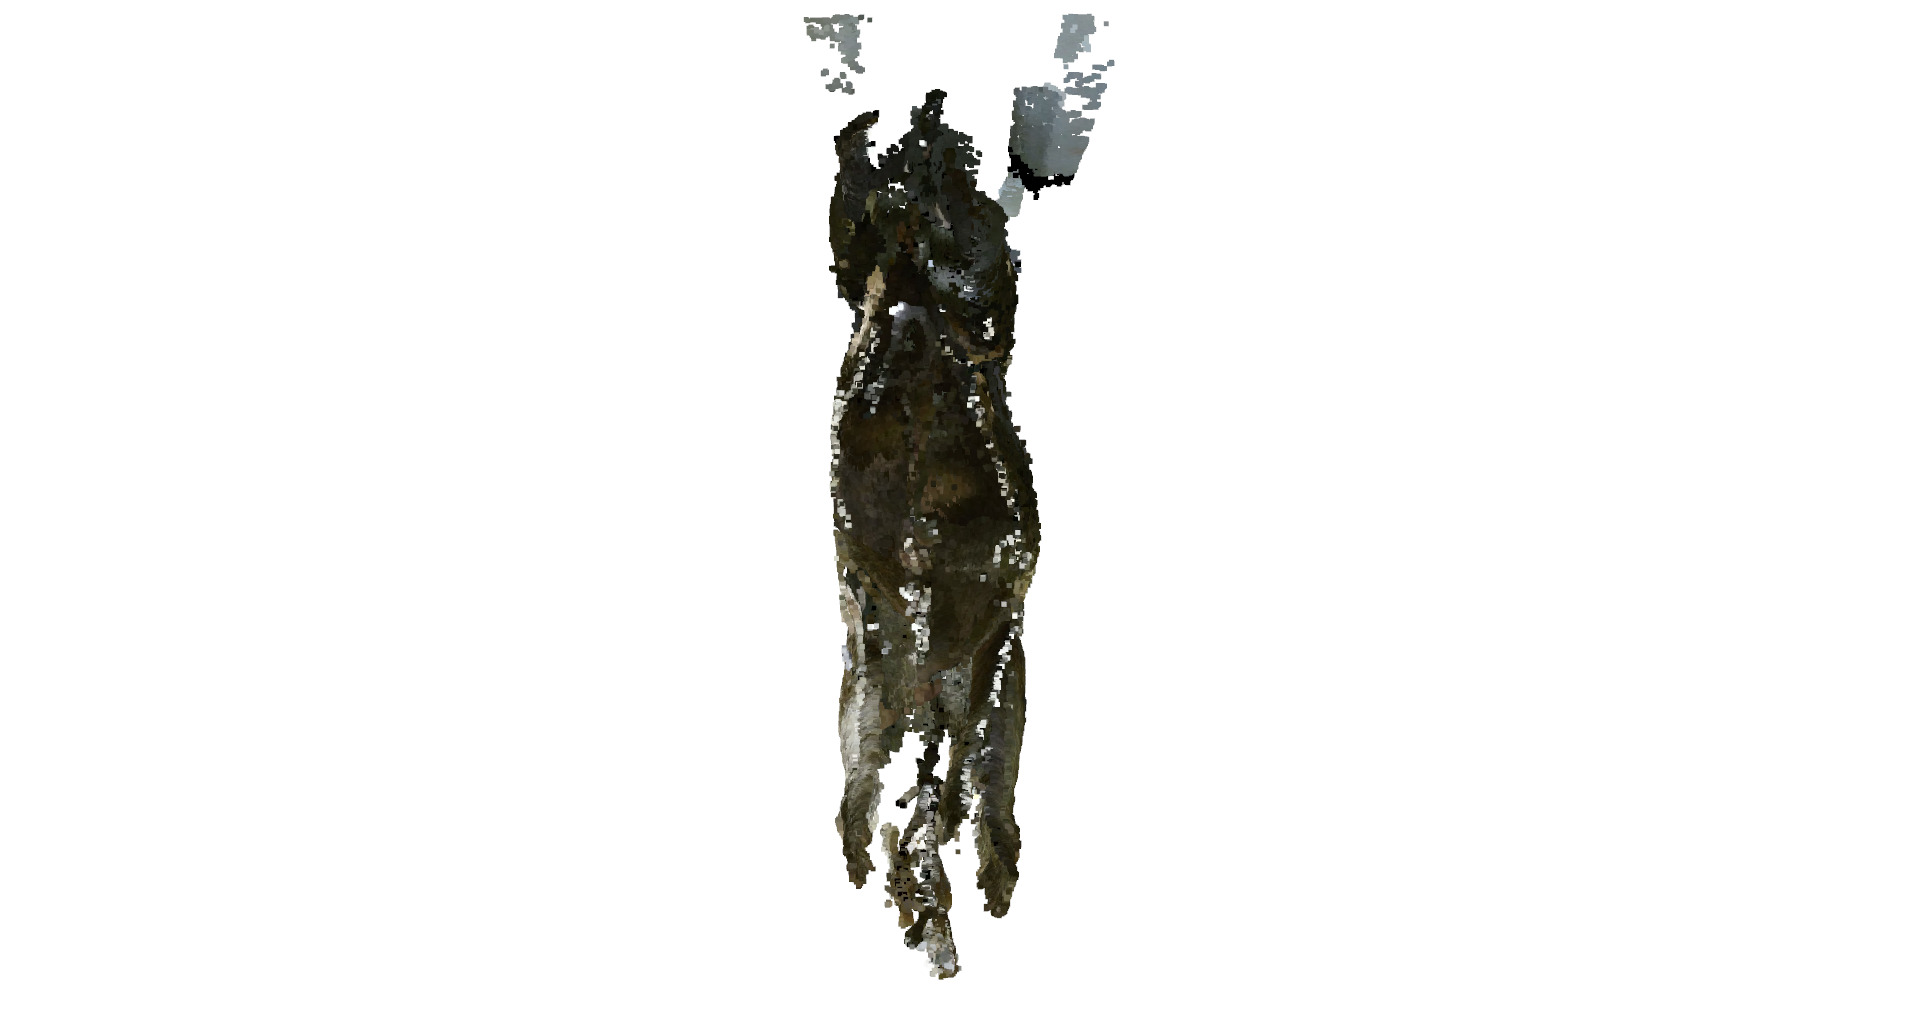

True

In [323]:
pcd_crop01 = crop_cow_176(pcd)
pcd_crop02 = crop02_176(pcd_crop01)
o3d.io.write_point_cloud("model_002.ply", pcd_crop02)

In [275]:
pwd

'/home/pupil/elitton/Cow_project'

# Register and Save Cow (auto)¶

In [28]:
filepath = '/home/pupil/elitton/Cow_project/new_images/all_unregistered/188_empty_plys/model_002'

left12


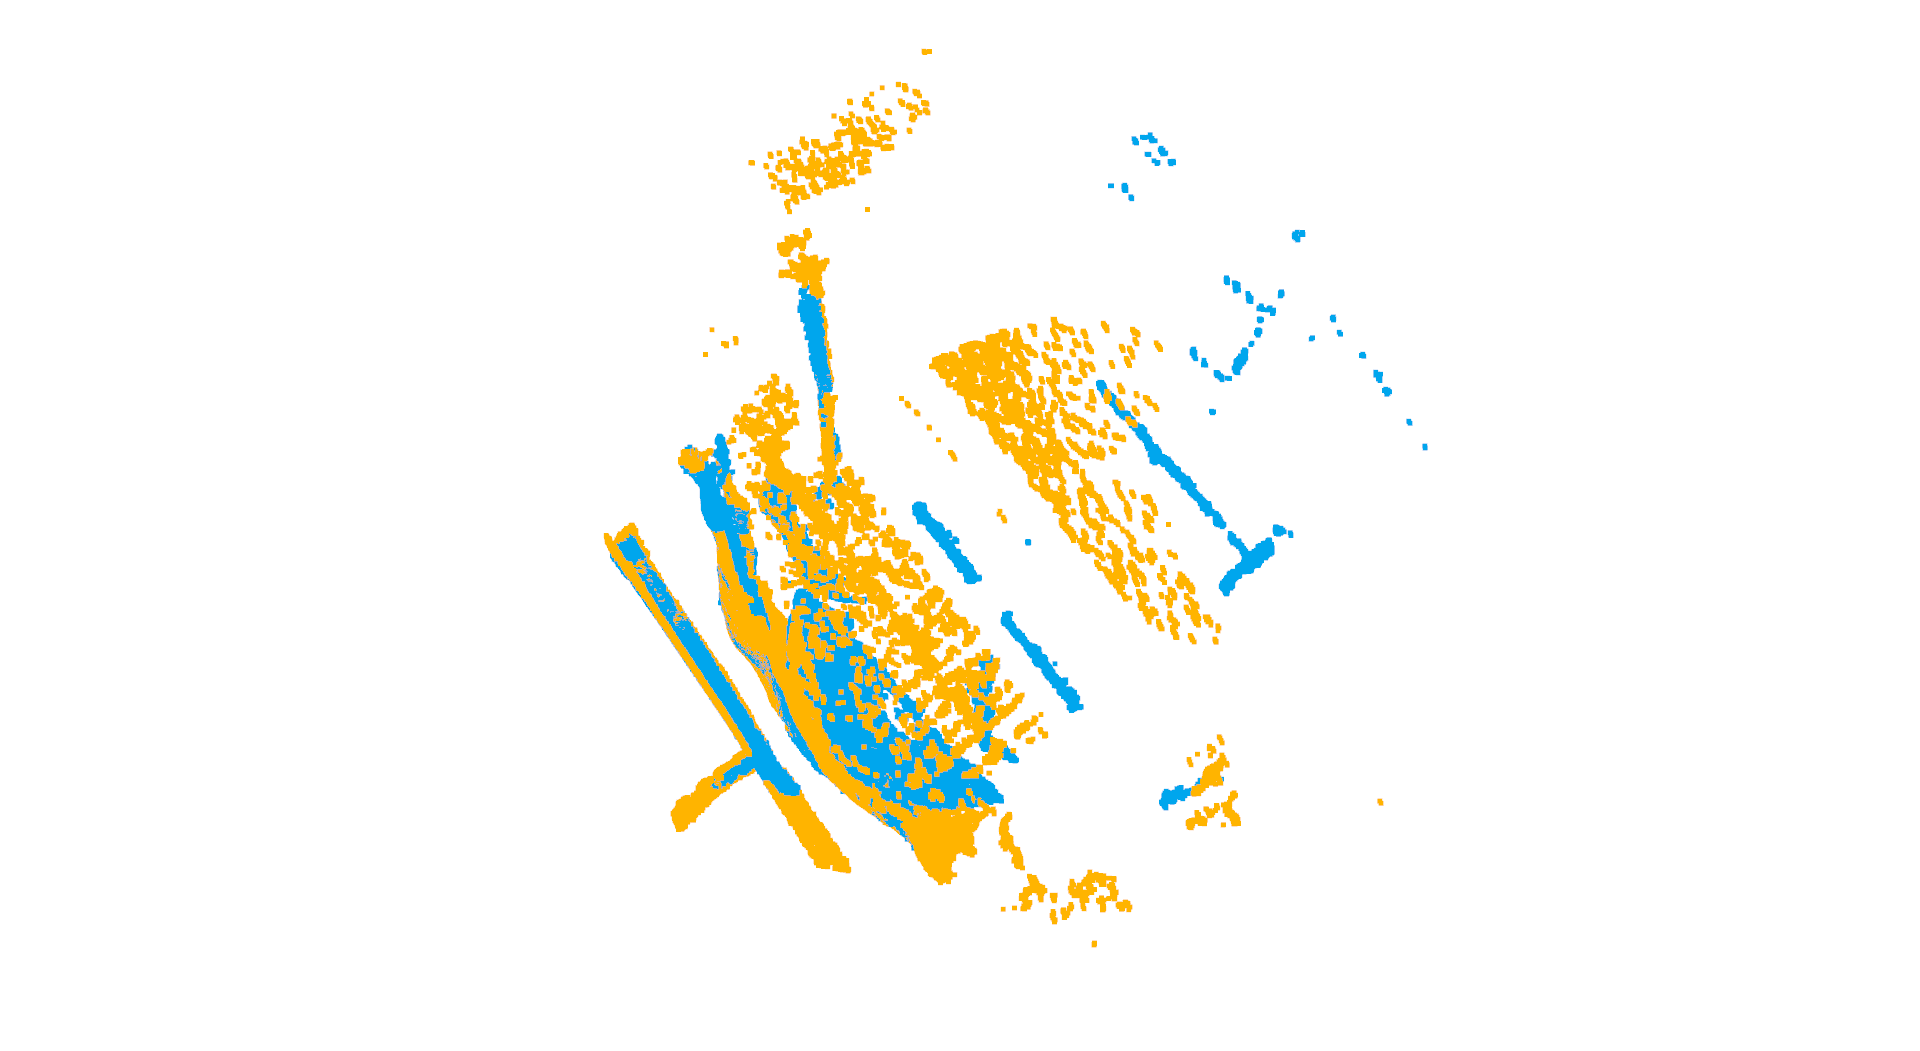

left31


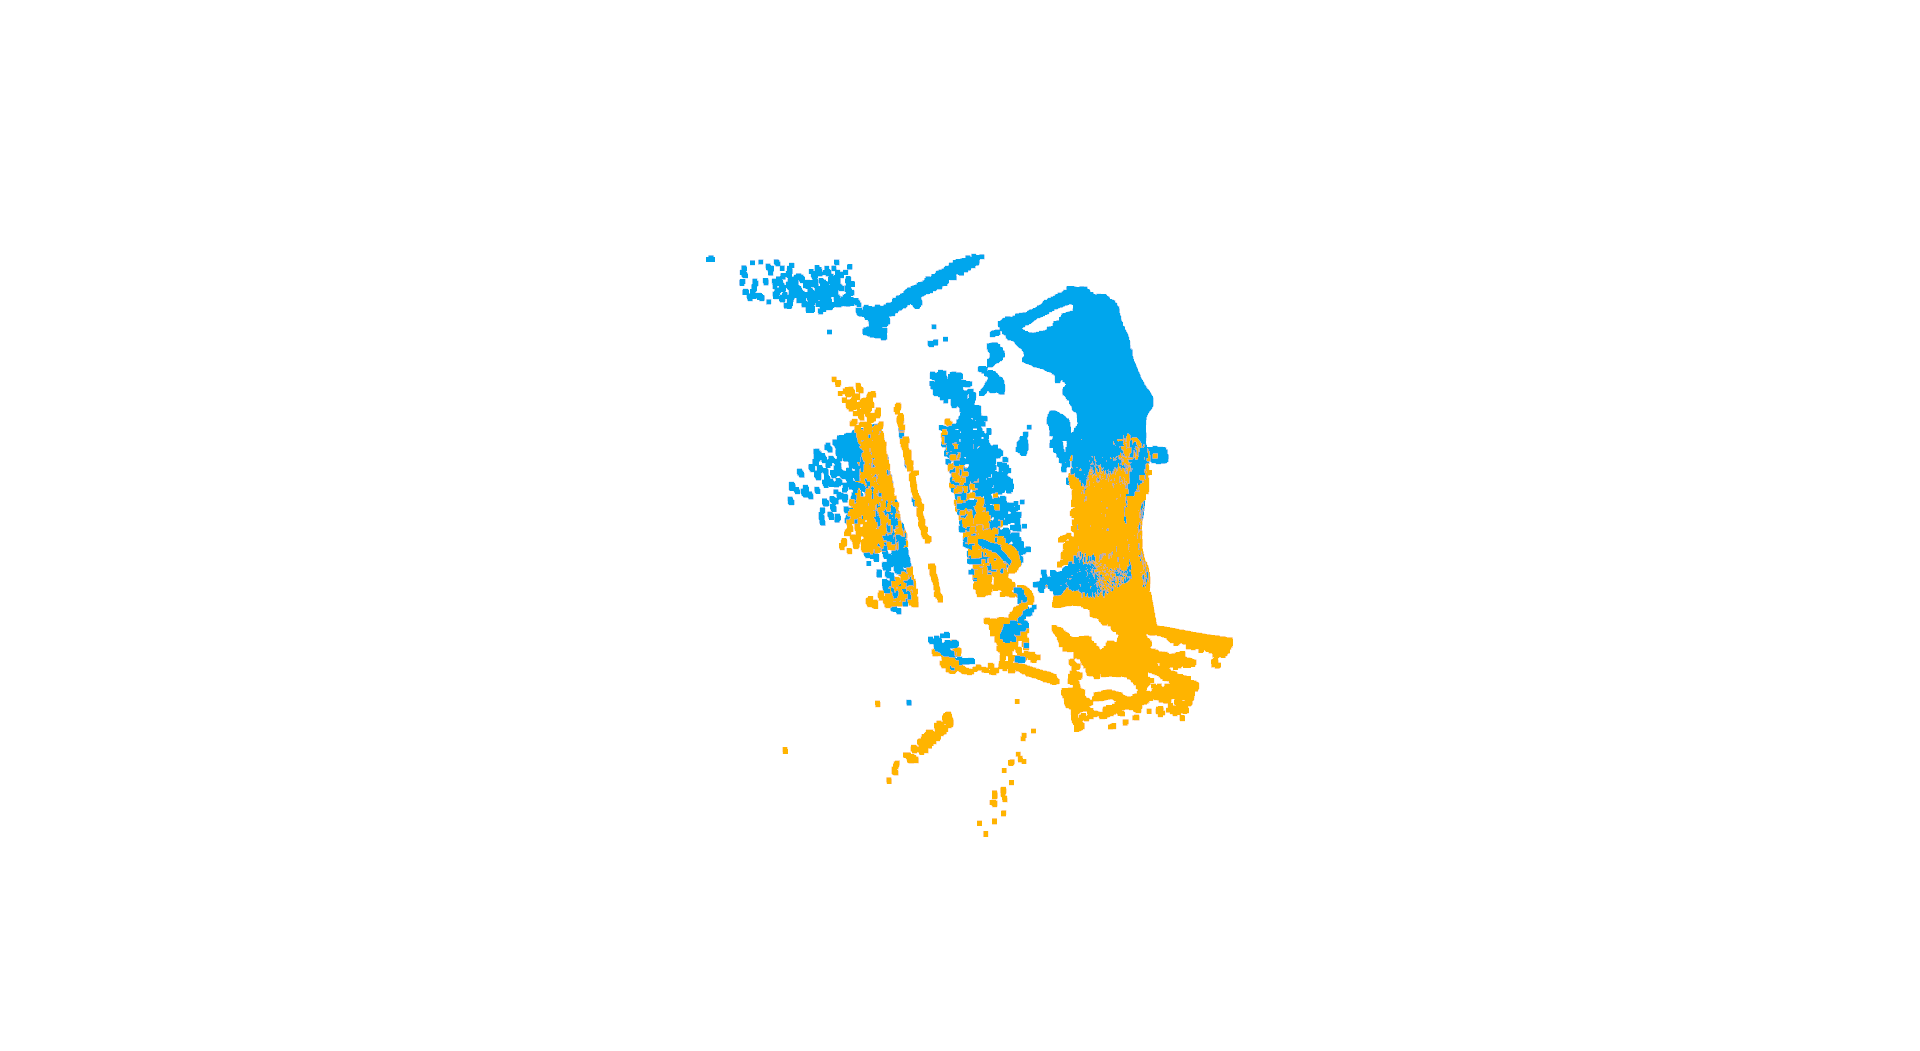

left34


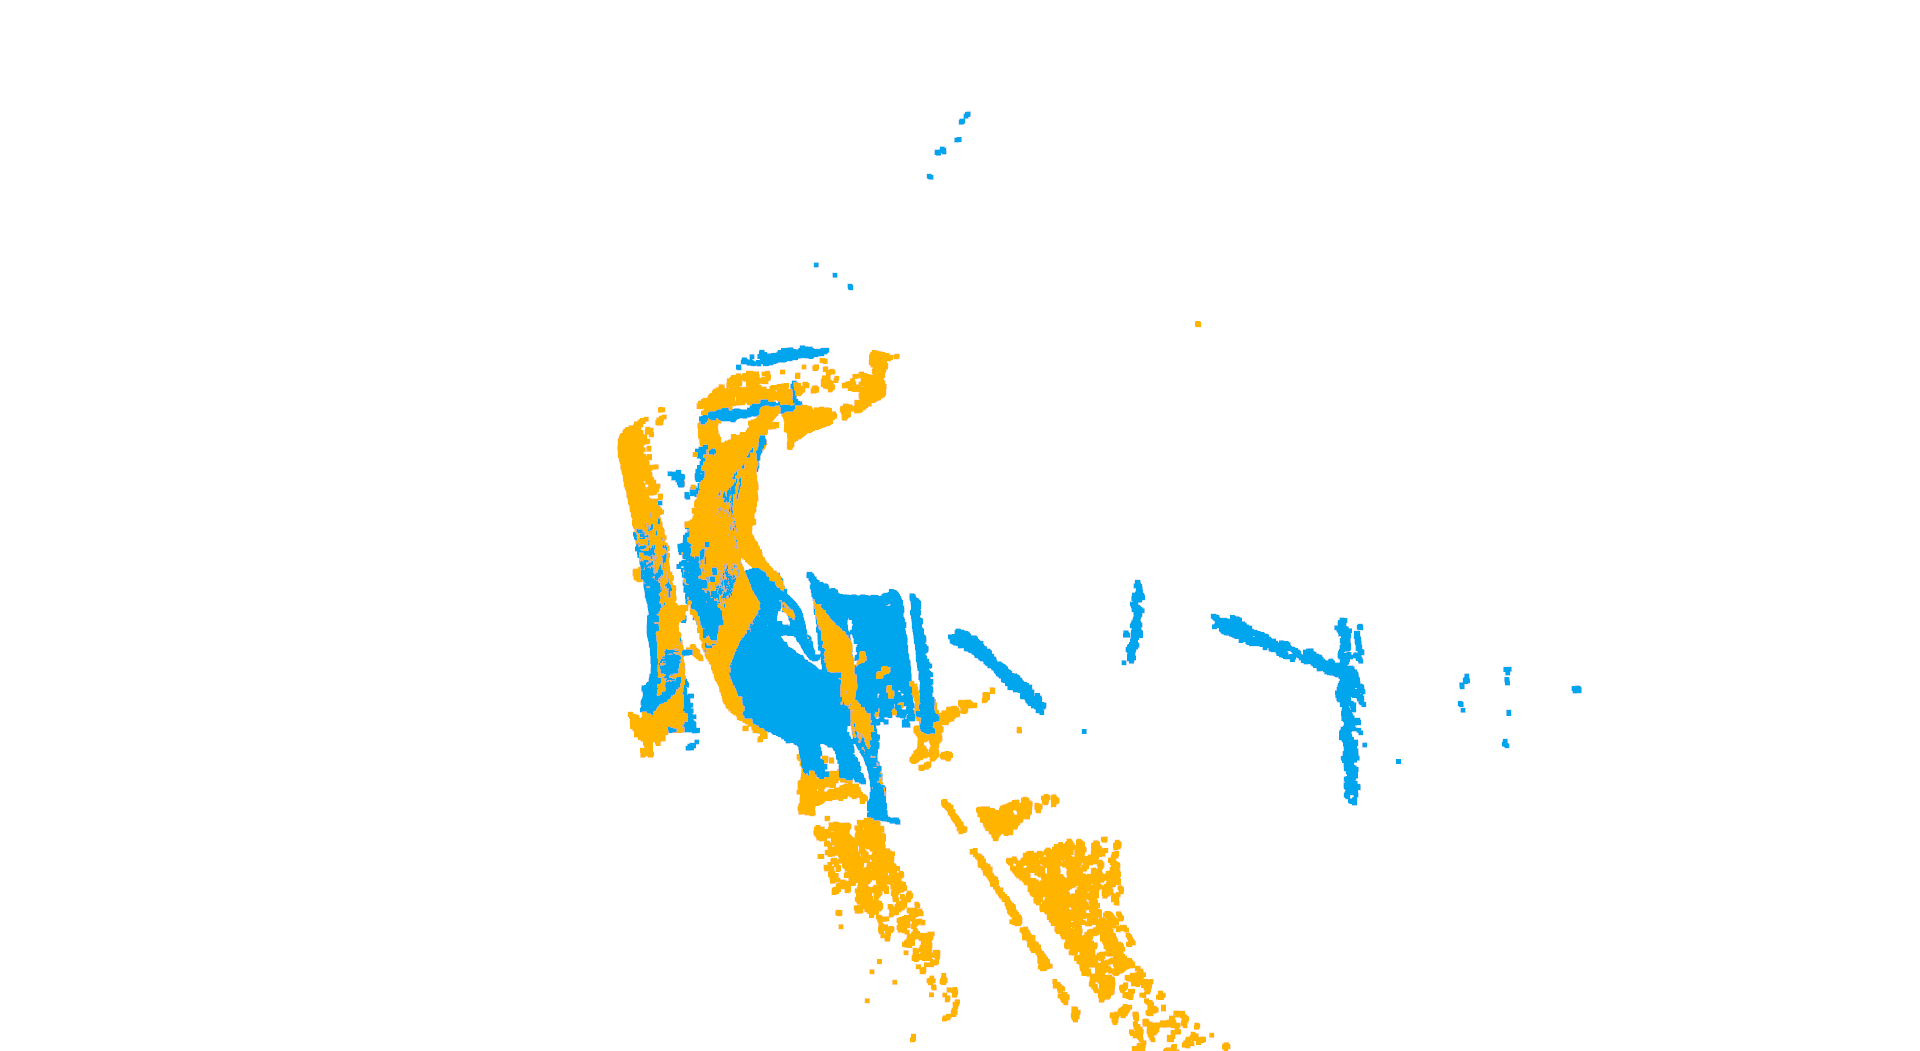

right56


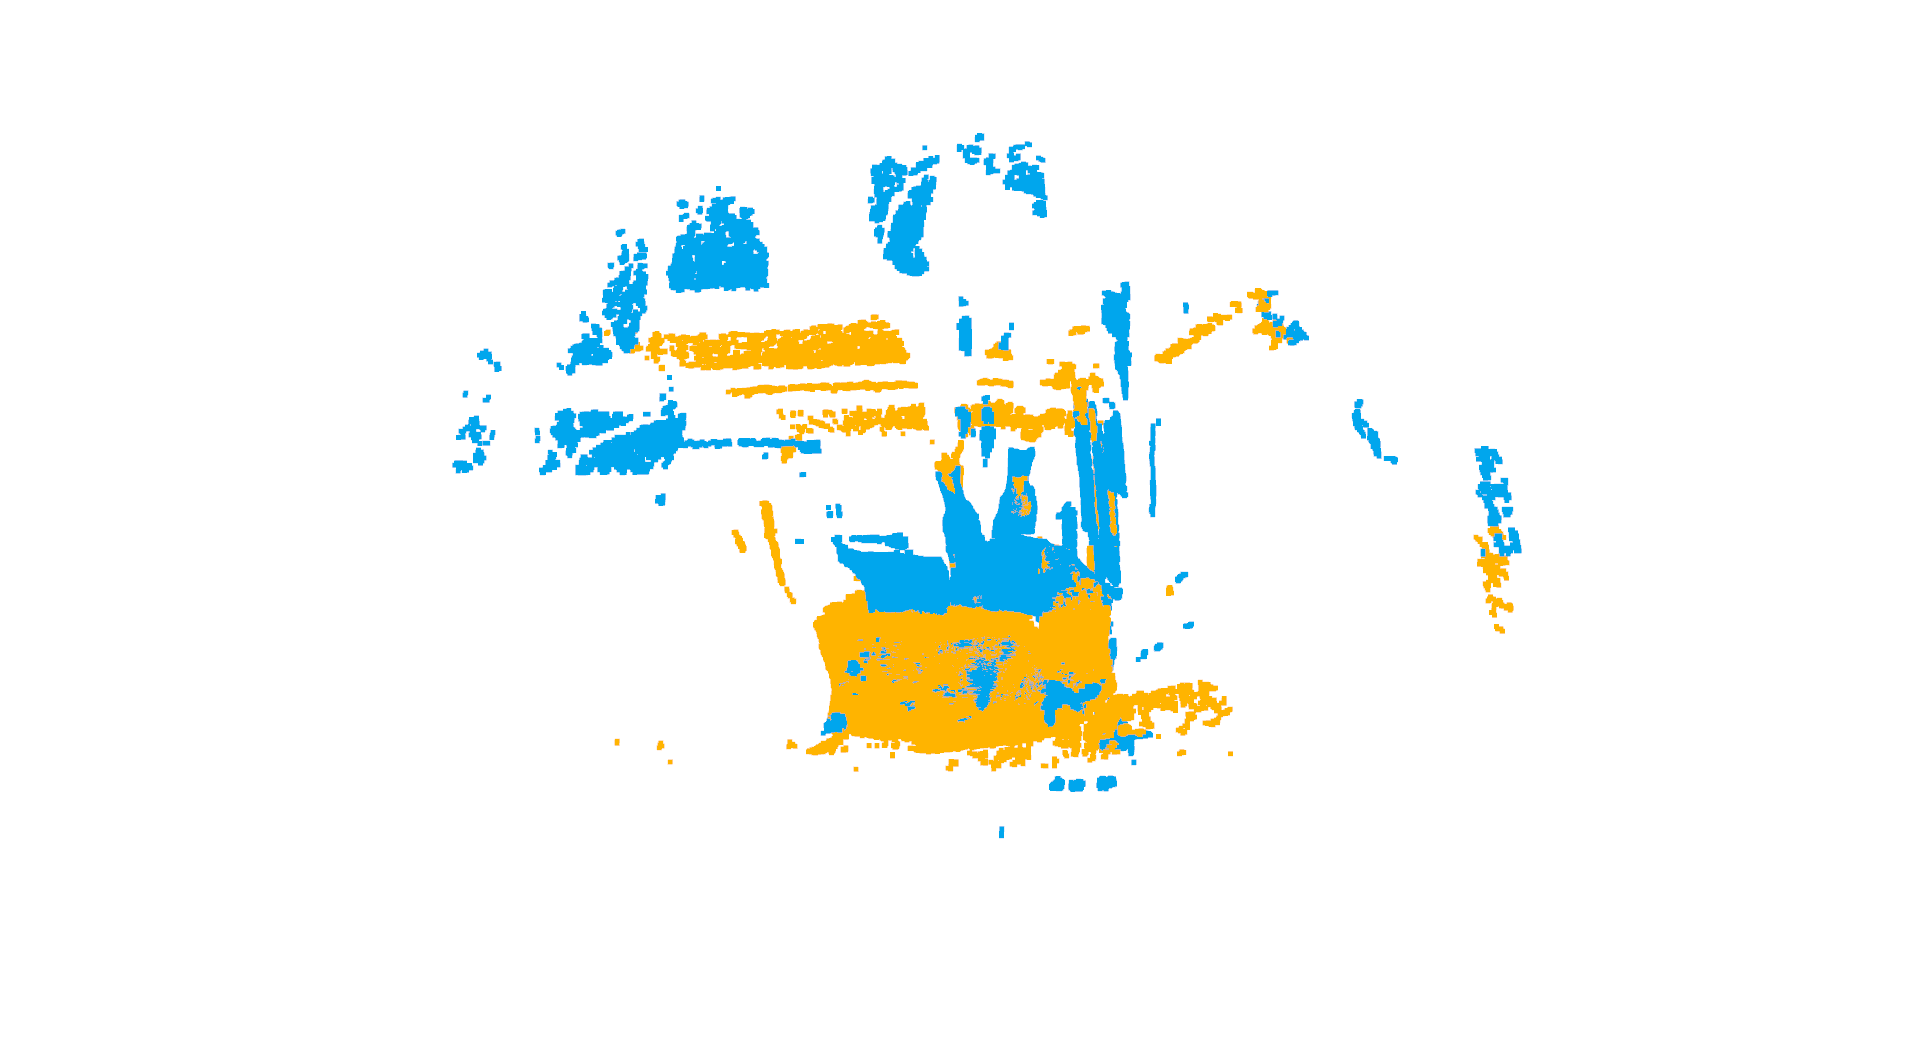

right57


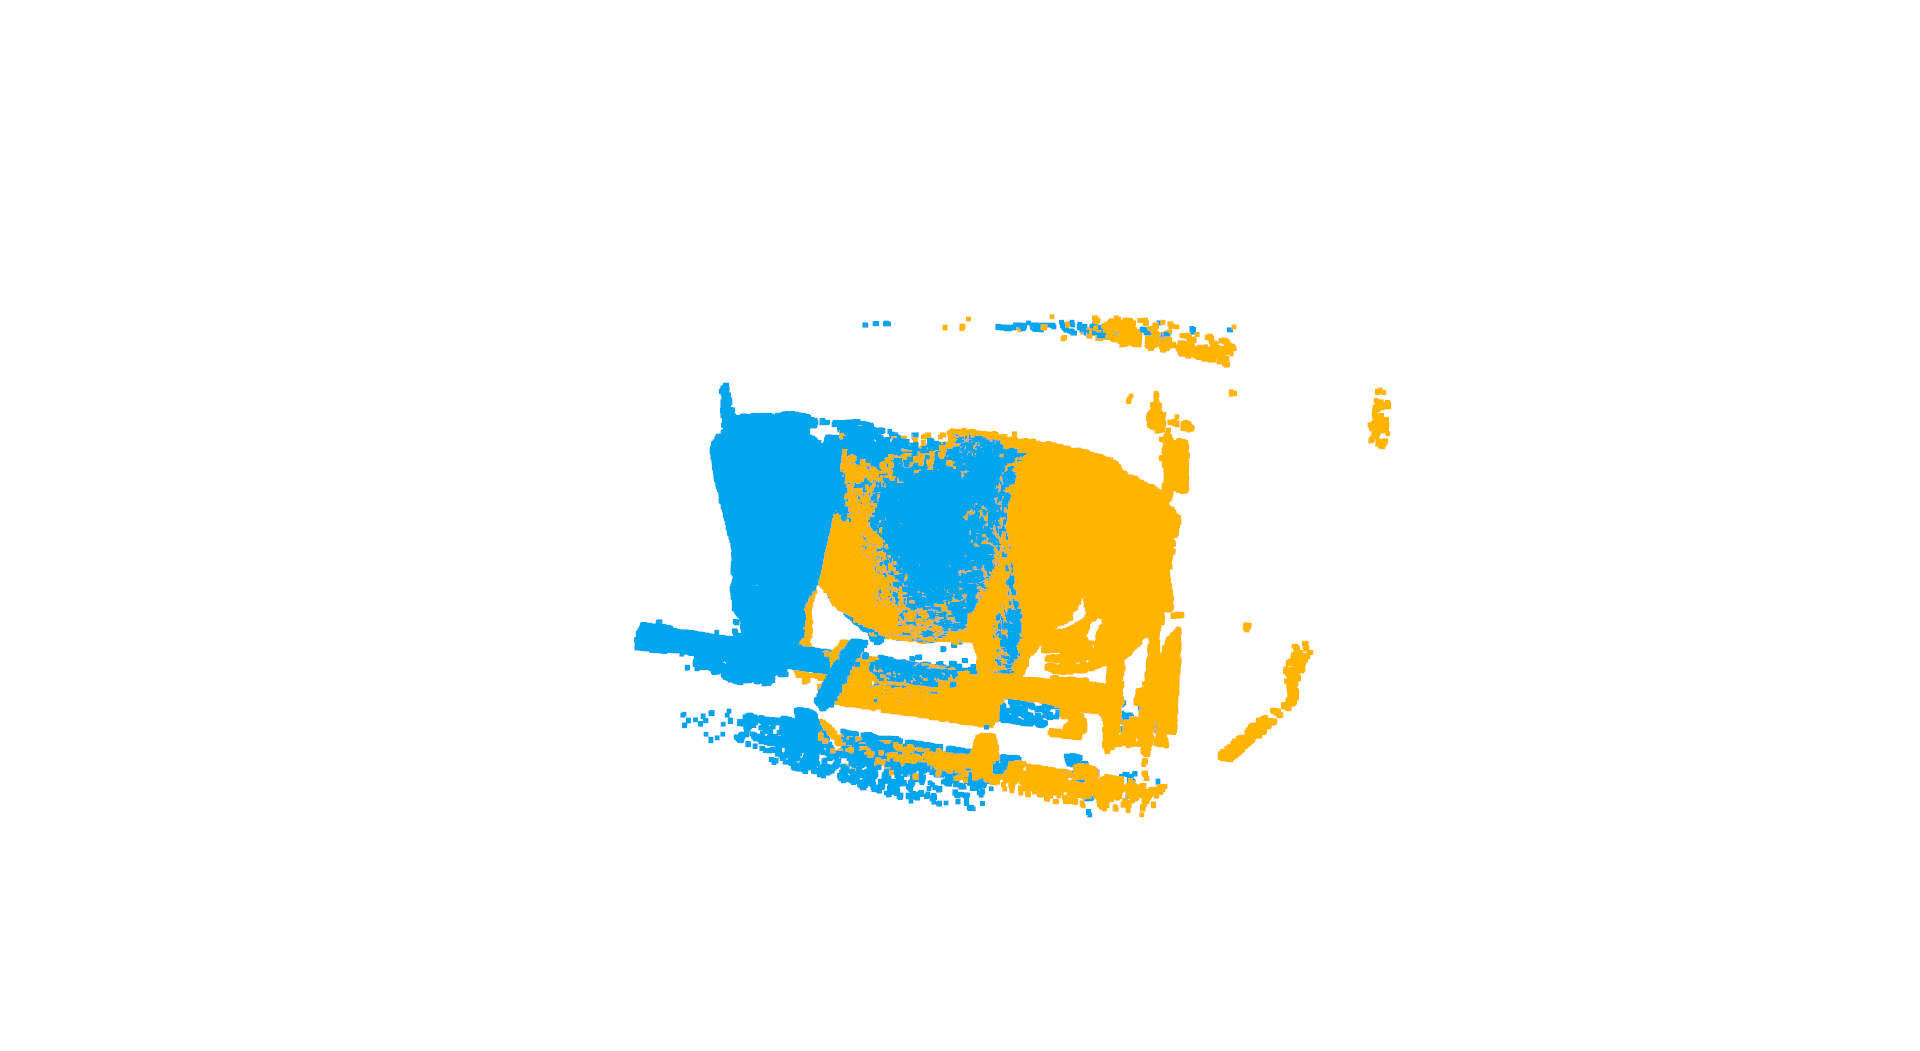

right78


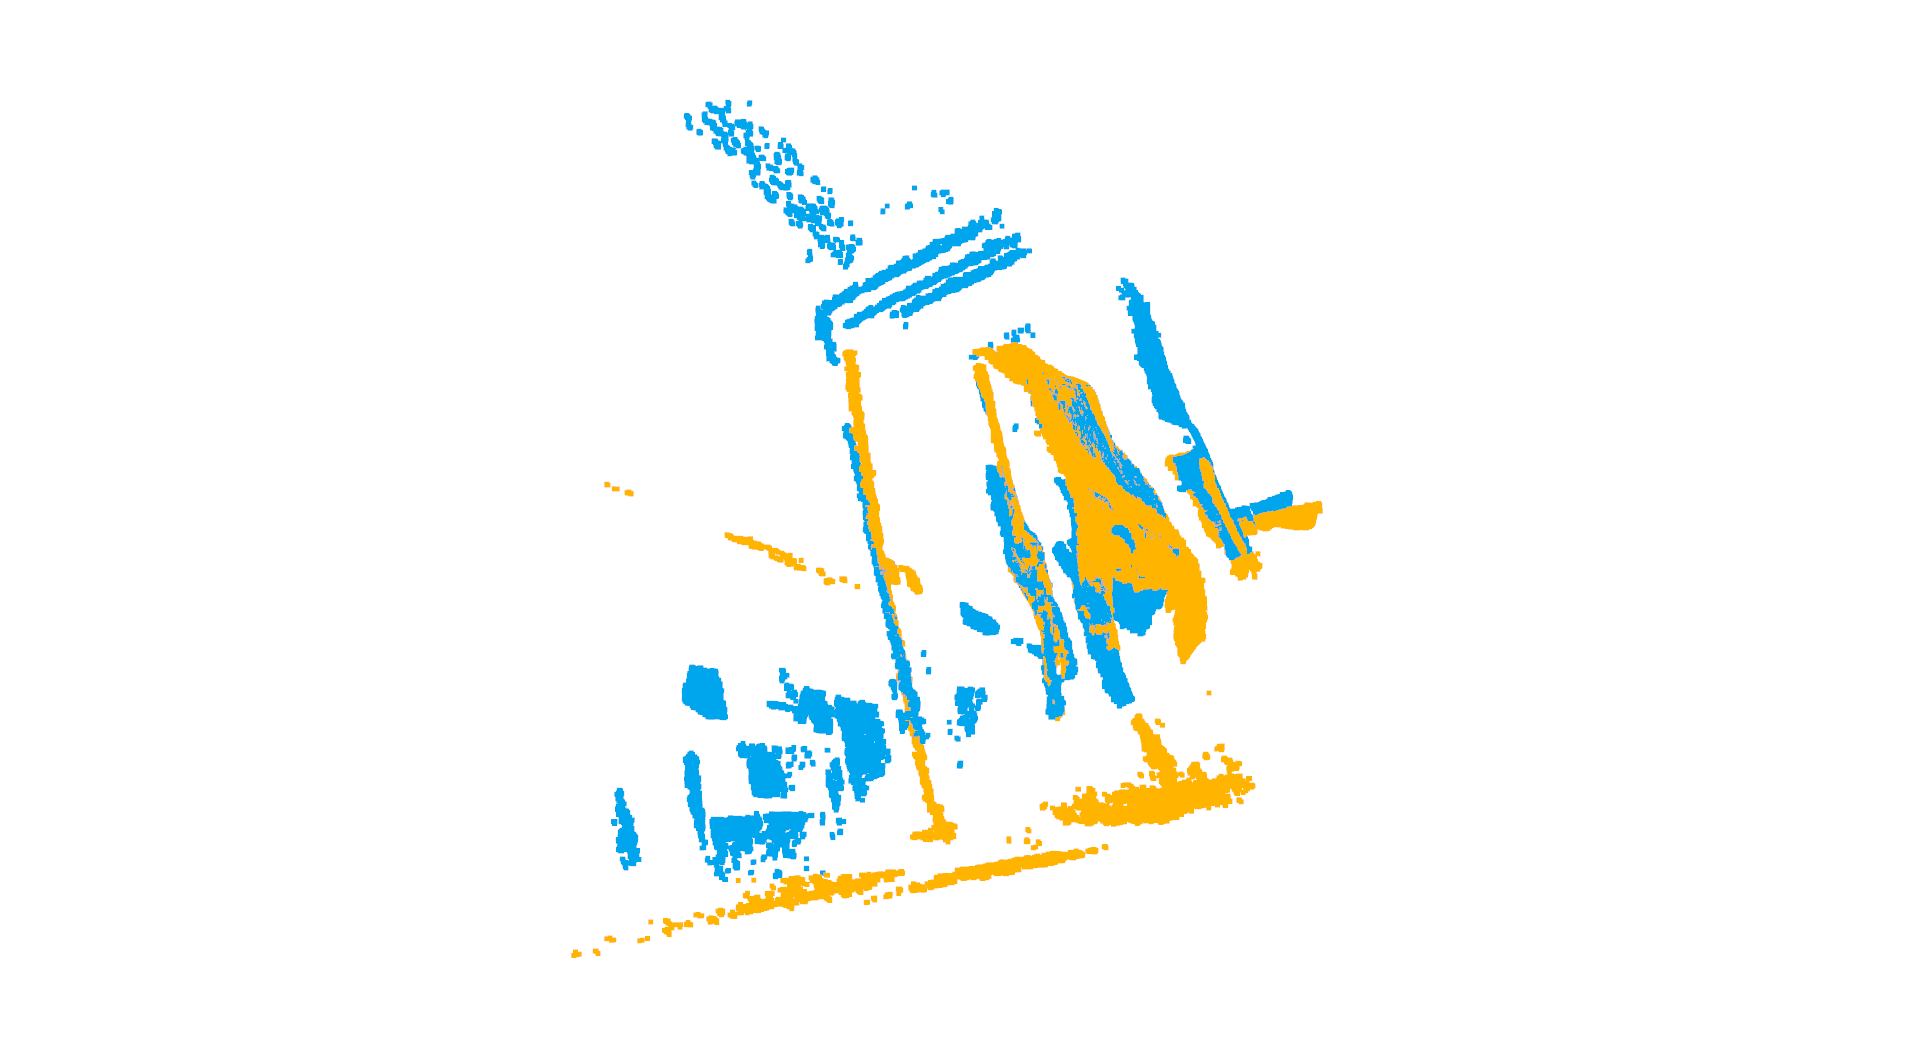

top93


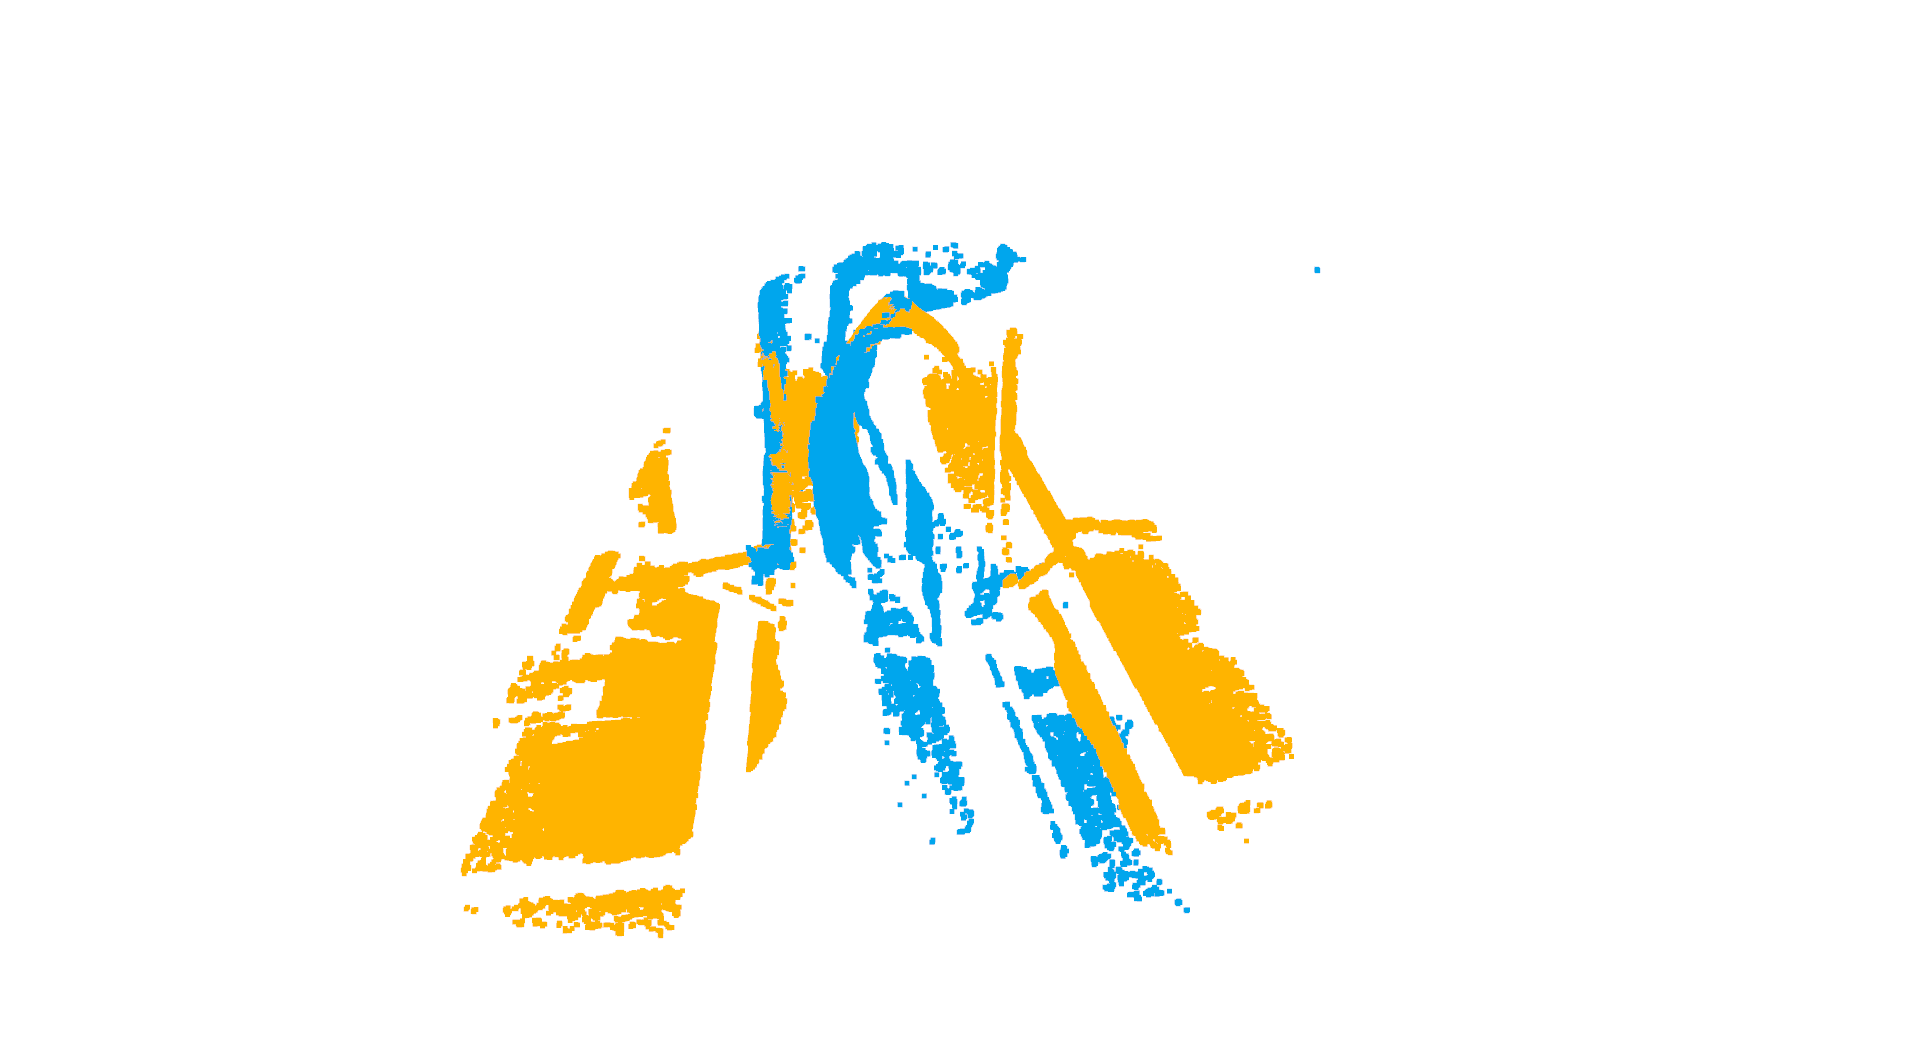

top95


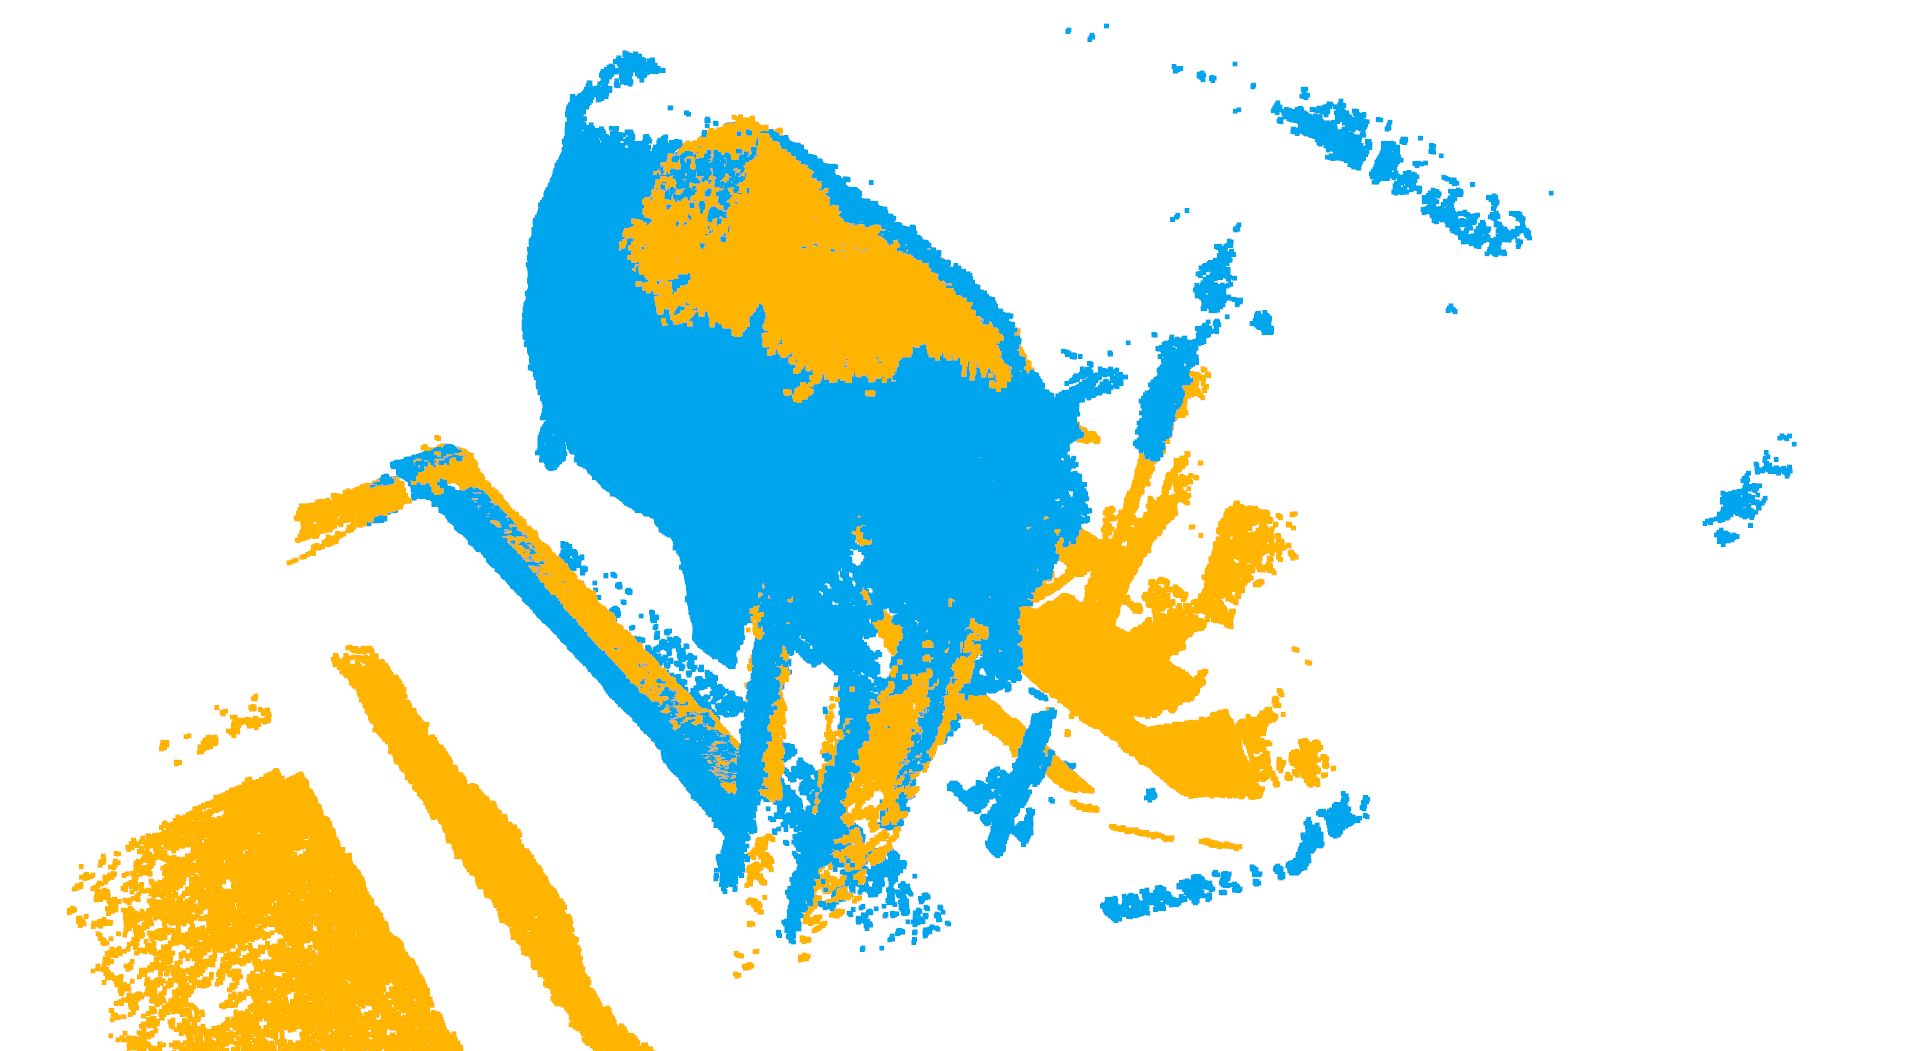

In [29]:
exp_pairs = ['left12','left31','left34','right56','right57','right78','top93','top95']
num_pairs = [[1,2],[3,1],[3,4],[5,6],[5,7],[7,8],[9,3],[9,5]]
for i in range(8):
    exp_name = exp_pairs[i]
    source_id = num_pairs[i][0]
    target_id = num_pairs[i][1]
    print(exp_name)
    source = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, source_id))
    target = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, target_id))
    trans_init = np.loadtxt('/home/pupil/elitton/Cow_project/initialization/empty_calibration/%s_transform.txt'% (exp_name), delimiter=',')
    #print("Perform point-to-point ICP refinement")

    threshold = 0.03 # 3cm distance threshold
    reg_p2p = o3d.pipelines.registration.registration_icp(source, target, threshold, trans_init,
                                                          o3d.pipelines.registration.TransformationEstimationPointToPoint(), o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=100))
    #print(reg_p2p.transformation)
    draw_registration_result(source, target, reg_p2p.transformation)
    np.savetxt('calibration/%s_transform.txt' % (exp_name), reg_p2p.transformation, delimiter=',')

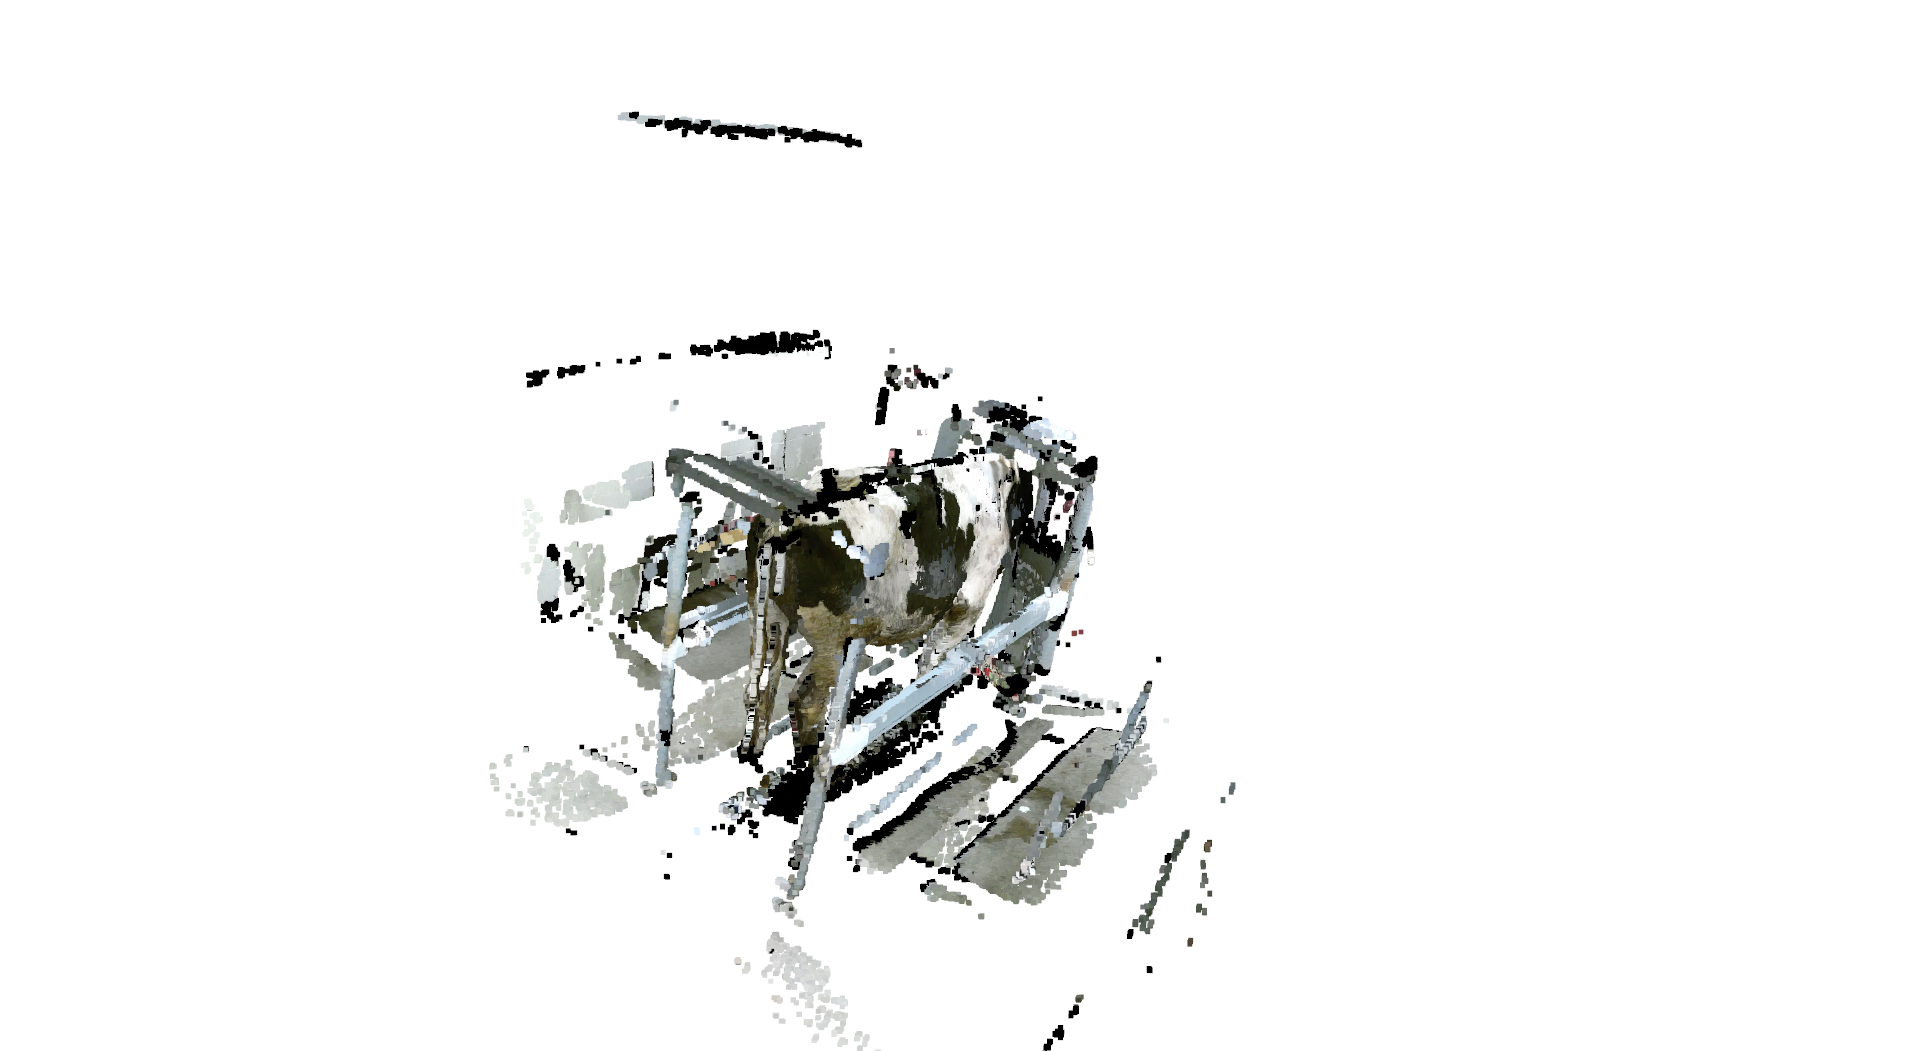

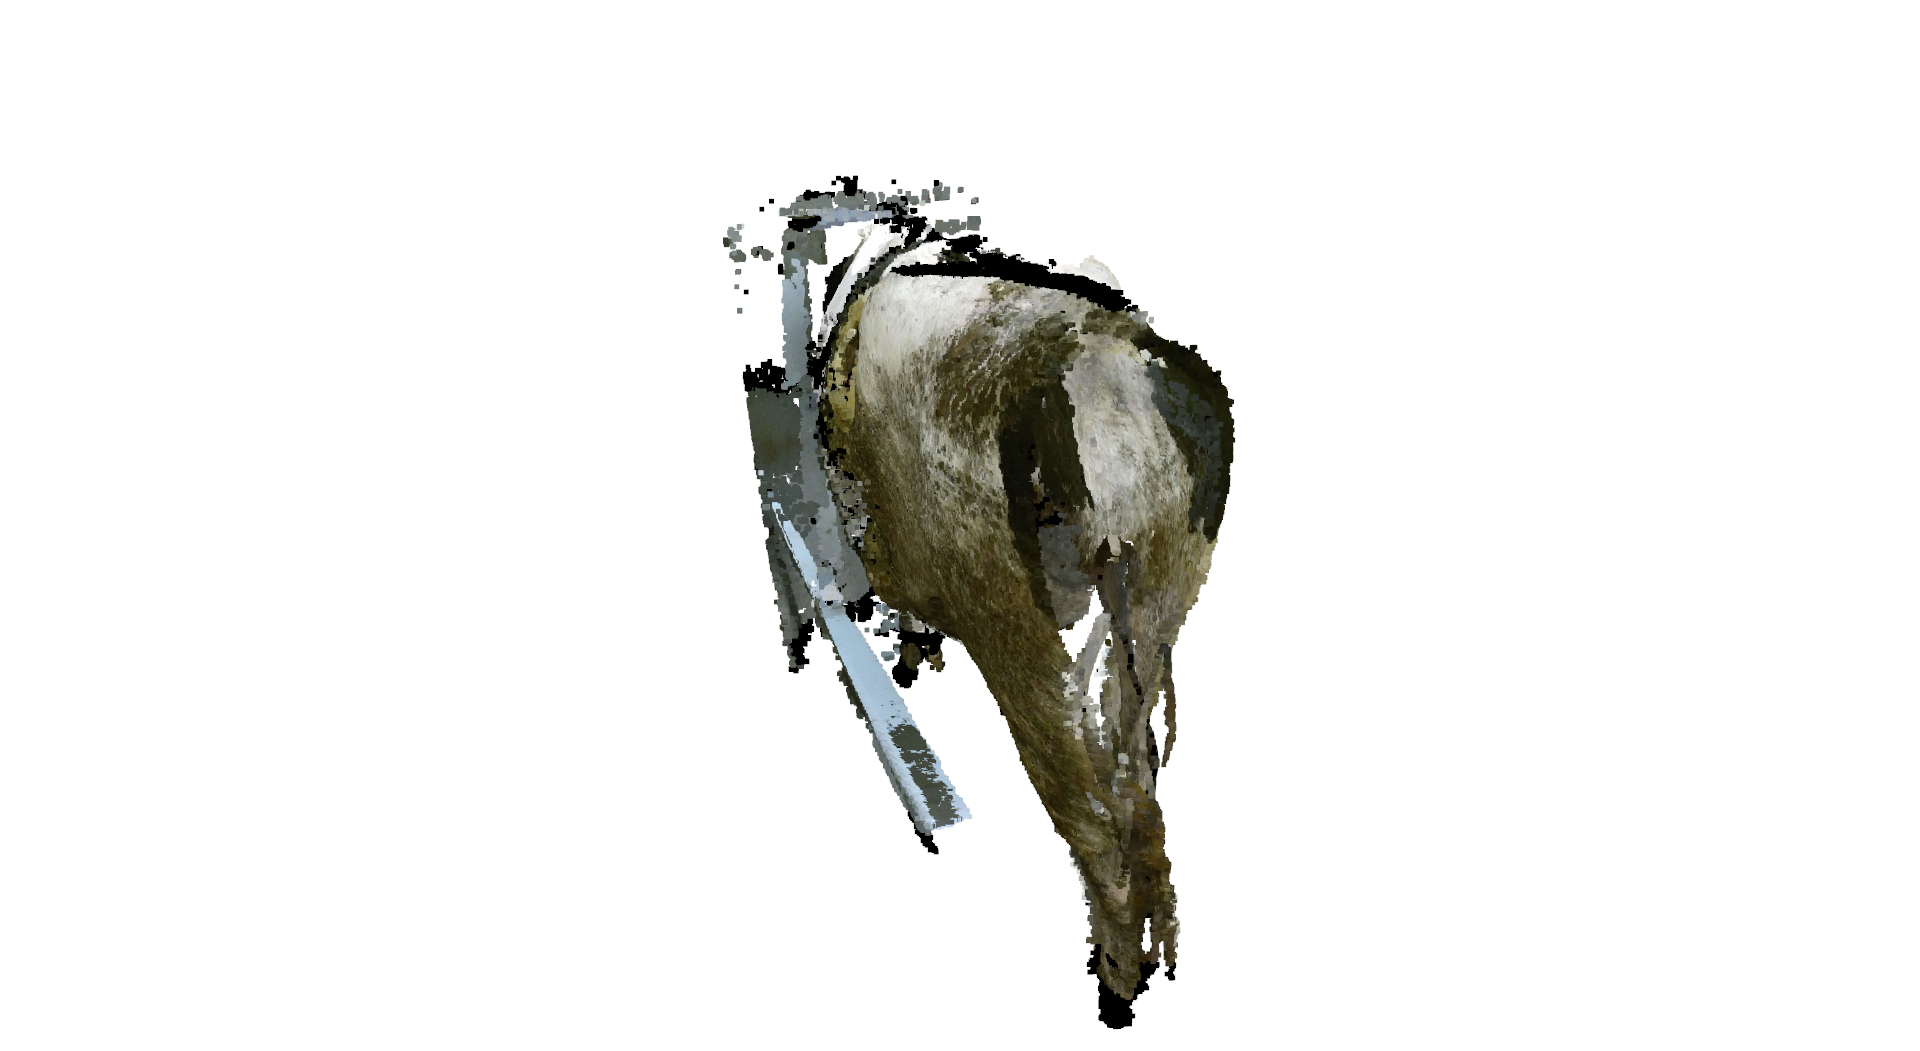

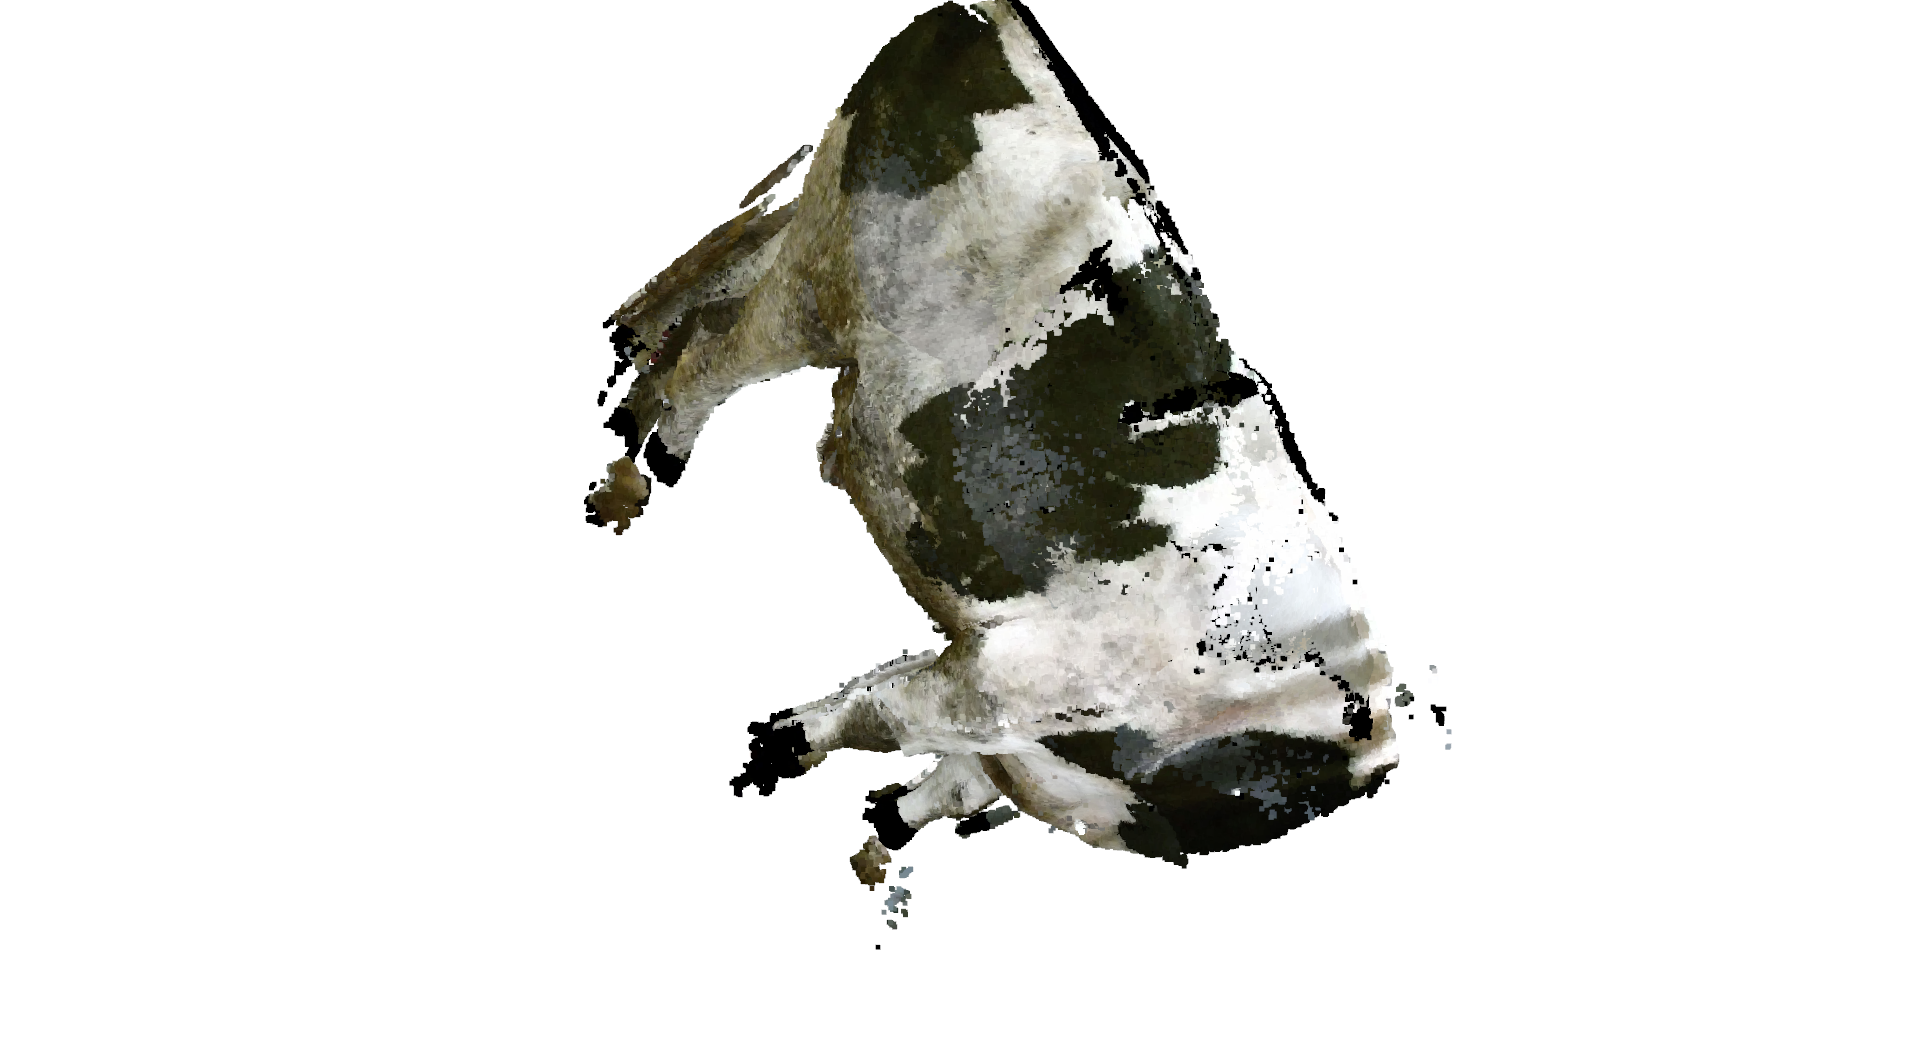

In [15]:
# registers all clouds crops

source  = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 9))

left1   = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 1))
left2   = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 2))
left3   = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 3))
left4   = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 4))

right5 = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 5))
right6 = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 6))
right7 = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 7))
right8 = o3d.io.read_point_cloud("%s/depthImg_001%d.ply" % (filepath, 8))

# Load all transformations
H93 = np.loadtxt('initialization/empty_calibration/top93_transform.txt', delimiter=',')
H95 = np.loadtxt('initialization/empty_calibration/top95_transform.txt', delimiter=',')

H31 = np.loadtxt('initialization/empty_calibration/left31_transform.txt', delimiter=',')
H34 = np.loadtxt('initialization/empty_calibration/left34_transform.txt', delimiter=',')
H12 = np.loadtxt('initialization/empty_calibration/left12_transform.txt', delimiter=',')

H56 = np.loadtxt('initialization/empty_calibration/right56_transform.txt', delimiter=',')
H57 = np.loadtxt('initialization/empty_calibration/right57_transform.txt', delimiter=',')
H78 = np.loadtxt('initialization/empty_calibration/right78_transform.txt', delimiter=',')

source_temp = copy.deepcopy(source)

left1_temp = copy.deepcopy(left1)
left2_temp = copy.deepcopy(left2)
left3_temp = copy.deepcopy(left3)
left4_temp = copy.deepcopy(left4)

right5_temp = copy.deepcopy(right5)
right6_temp = copy.deepcopy(right6)
right7_temp = copy.deepcopy(right7)
right8_temp = copy.deepcopy(right8)

left3_temp.transform(inv(H93))
left1_temp.transform(inv(H93) @ inv(H31))
left4_temp.transform(inv(H93) @ inv(H34))
left2_temp.transform(inv(H93) @ inv(H31) @ inv(H12))

right5_temp.transform(inv(H95))
right6_temp.transform(inv(H95) @ inv(H56))
right7_temp.transform(inv(H95) @ inv(H57))
right8_temp.transform(inv(H95) @ inv(H57) @ inv(H78))

# draws fully registered cow
pcd = o3d.geometry.PointCloud()
pcd = source_temp + left1_temp + left2_temp + left3_temp + left4_temp + right5_temp + right6_temp + right7_temp + right8_temp
o3d.visualization.draw_geometries([pcd]) 

# crops and draws cow 
pcd_crop = cow_crop(pcd, empty_176) # change parameter based on cow 

# crops legs and tail
pcd_crop2 = cow_crop(pcd_crop, legs_188) # change parameter based on cow

In [16]:
ply_name = filepath[-9:]
print('%s.ply' % ply_name)
o3d.io.write_point_cloud('%s.ply'% ply_name, pcd_crop) # saves crop ply
#  writes into Home/Cow_project/

model_001.ply


True

In [25]:
pwd

'/home/pupil/elitton/Cow_project'